## imports

In [1]:
import numpy as np
import pandas as pd
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy, pearsonr, ttest_1samp
from scipy.spatial.distance import cdist
from collections import OrderedDict
from decimal import Decimal
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hypertools as hyp
import os
import re
import pickle

%matplotlib inline
sns.set_context('talk')

In [145]:
q1 = '../../data/testvideoquestions'
q2 = '../../data/khan_questions_raw.txt'

with open(q1, 'r', encoding='utf-8') as f:
    q1 = f.read()
with open(q2, 'r', encoding='utf-8') as f:
    q2 = f.read()

In [151]:
for n, (i, j), in enumerate(zip(q1.splitlines(), q2.splitlines())):
    if i != j:
        print(n)
        print(i)
        print(j)
        print()

0
Note: for each question, the correct answer is the first answer
﻿Note: for each question, the correct answer is the first answer

1

 

11

 

19

 

30
Why don't you and your computer experience any attraction or repulsion due to the Weak Interaction?
Why don’t you and your computer experience any attraction or repulsion due to the Weak Interaction?

34
Neither you nor your computer has enough mass to induce a significant Weak Interaction
Neither you nor your computer has enough mass to induce a significant Weak Interaction 

35

 

43

 

47
View them in different frames of reference
View them in different frames of reference 

51

 

54
Which of the following are the primary two fundamental forces acting in opposition between the positively-charged protons in an atom's nucleus?
Which of the following are the primary two fundamental forces acting in opposition between the positively-charged protons in an atom’s nucleus?

59

 

63
Positive and negative charges cancel out and become

In [150]:
q2.splitlines()

['\ufeffNote: for each question, the correct answer is the first answer',
 ' ',
 'Video 1 Questions',
 '',
 '1. Corresponding time in video (approximate): 1:00; conceptual question',
 '',
 'Why is the gravitational attraction between you and your computer too small for you to notice?',
 'Neither you nor your computer has enough mass to cause a noticable gravitational attraction',
 'You and your computer are too close for the gravitational attraction to be significant',
 'Humans are too small to detect the force of gravity',
 'The gravitational attraction between you and your computer is disrupted by the larger gravitational field generated by the earth',
 ' ',
 '2. Corresponding time in video (approximate): 1:45; factual question',
 '',
 'Which of the following is an example of the Weak Interaction?',
 'A neutron in a radioactive Cesium atom is converted into a proton, leading to the release of a few particles',
 'Light from the sun collides with a satellite orbiting Earth and exerts a

## set paths

In [2]:
vid_transc_dir = '../video-transcript-analysis'
answers_dir = '../graded-answers/'
figdir = '../../figures/'

## load lesson and question data

In [3]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
forces_video_samples = forces_video_df[0].tolist()

In [4]:
# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [5]:
# load question data

# question types:
#  - 1: Four Forces
#  - 2: Birth of stars
#  - 0: general knowledge questions
questions_df = pd.read_csv('../data-analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

In [6]:
questions_df.head()

video                                           question  \
index                                                             
1          1  Why is the gravitational attraction between yo...   
2          1  Which of the following is an example of the We...   
3          1  Roughly how many times stronger is the Weak In...   
4          1  Why don't you and your computer experience any...   
5          1  Which of the following is a difference between...   

                                                   ans_A  \
index                                                      
1      Neither you nor your computer has enough mass ...   
2      A neutron in a radioactive Cesium atom is conv...   
3                     10,000,000,000,000,000,000,000,000   
4      The weak interaction only acts over extremely ...   
5      Gravity is only ever attractive while the elec...   

                                                   ans_B  \
index                                                      
1      You and your computer are too close for the gr...   
2      Light from the sun collides with a satellite o...   
3                                                     10   
4      The weak interaction between you and your comp...   
5      Gravity is a much more powerful force than ele...   

                                                   ans_C  \
index                                                      
1      Humans are too small to detect the force of gr...   
2      Two protons bound together in a Helium nucleus...   
3                                              1,000,000   
4               You and your computer have no net charge   
5      Gravity can only act over large distances whil...   

                                                   ans_D  
index                                                     
1      The gravitational attraction between you and y...  
2      A distant galaxy exerts a small but detectable...  
3       The Weak Interaction is less strong than gravity  
4      Neither you nor your computer has enough mass ...  
5      The electromagnetic force can only act over sm...

In [7]:
# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

## load and format participant answer data

In [8]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19f_49.csv'), index_col='Unnamed: 0')

In [9]:
# sub_data format - {participantID : dataframe}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

correct?  qID  set  video
0         1   13    0      1
1         0   21    0      2
2         0   12    0      1
3         1   16    0      2
4         1   28    0      2

## define some functions

In [10]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 20,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [11]:
def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
    """
    Fit a topic model to video and question content, use it to transform videos and questions.
    Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
    """
    
    # initialize count vectorizer
    tf_vectorizer = CountVectorizer(**vec_params)
    # fit the model
    tf_vectorizer.fit(v_windows+q_windows)

    # transform video windows
    video_tf = tf_vectorizer.transform(v_windows)

    # transform question samples
    questions_tf = tf_vectorizer.transform(q_windows)

    both_tf = tf_vectorizer.transform(v_windows+q_windows)

    # initialize topic model
    lda = LatentDirichletAllocation(**lda_params)

    # fit topic model to video and questions
    lda.fit(both_tf)

    # transform video
    video_topics = lda.transform(video_tf)

    # smooth video model
    video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

    # transform questions
    questions_topics = lda.transform(questions_tf)
    
    return video_topics, questions_topics, lda


In [12]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [13]:
def pcorrect_msd(video_topics, subject, n_questions, n_perms, p_correct = [0, .05, .25, .50, .75, .95, 1]):
    """
    Function that computes the MSD between video and question models as a function of p(correct answer)
    """
    
    dist = []
    for pc in p_correct:
        dists = []
        for perm in range(n_perms):
            acc = np.random.binomial(1, pc, n_questions).astype(int)
            recon = forces_traces_by_sub[subject]
            dists.append(np.mean(video_topics-recon)**2)
        dist.append(dists)
    return dist

In [14]:
all_stopwords = stopwords.words('english') + ["let's", "they'd", "they're", "they've", "they'll", "that's", 
                                              "I'll", "I'm"]

In [15]:
def format_text(text):
    """
    Function to format documents for tokenization and modeling
    """
    
    clean_text = []
    
    for sentence in text:
        no_punc = re.sub("[^a-zA-Z\s']+", '', sentence.lower())
        no_stop = ' '.join([word for word in no_punc.split() if word not in all_stopwords])
        clean = re.sub("'+", '', no_stop)
        clean_text.append(clean)
    
    return clean_text

In [16]:
def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

In [17]:
def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [18]:
def corr_mean(rs, axis=0):
    """
    Function that calculates the mean of correlation coefficients,
    performing Fisher z-transformation and inverse z-transormation
    
    Parameters
    ----------
    rs: : list or ndarray
        Correlation values
    
    Returns
    ----------
    result : float
        mean of correlation values

    """
    return _z2r(np.nanmean([_r2z(r) for r in rs], axis=axis))

# _Four Forces_

### model lecture video and questions

In [19]:
# forces_v_traj, forces_q_traj, forces_tm = model_lessons_questions(forces_video_samples, forces_questions_samples, 
#                                                            vec_params, lda_params)

In [20]:
# sns.heatmap(forces_v_traj, vmin=0, vmax=1)
# plt.title('Four Forces lecture topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Time')
# # plt.savefig(figdir+'forces-lecture-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

# sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
# plt.title('Four Forces questions topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Question')
# # plt.savefig(figdir+'forces-questions-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

In [21]:
# sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1)
# plt.title('Four Forces lecture temporal correlation matrix')
# plt.xlabel('Time')
# plt.ylabel('Time')
# # plt.savefig(figdir+'forces-lecture-corrmat.pdf', bbox_inches='tight')
# plt.show()

In [22]:
# sns.set_context('notebook')
# hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
#          legend=['Lecture content', 'Question content'])
# plt.show()

### What moments of lecture content does each question cover?

In [23]:
# sns.set_palette('hls')
# sns.set_context('talk')

In [24]:
# plt.figure(figsize=(8,5))
# plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
# plt.xlabel('Video timepoint')
# plt.ylabel('Video-question\ntopic correlation')
# plt.title('Four Forces: lecture-question content similarity')
# plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
# plt.grid(False)
# # plt.savefig(figdir+'forces-v-q-similarity.pdf', bbox_inches='tight')
# plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [25]:
# forces_traces_set0 = {}
# forces_traces_set1 = {}
# forces_traces_set2 = {}

# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in first block 
#     set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
#     # extract their topic vectors by index
#     set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
#     # get accuracy for those questions
#     set0_fqs_acc = set0_fqs['correct?']
    
#     forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in second block 
#     set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
#     # extract their topic vectors by index
#     set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
#     # get accuracy for those questions
#     set1_fqs_acc = set1_fqs['correct?']
    
#     forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in third block 
#     set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
#     # extract their topic vectors by index
#     set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
#     # get accuracy for those questions
#     set2_fqs_acc = set2_fqs['correct?']
    
#     forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [26]:
# avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
# avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
# avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [27]:
# sns.set_context('notebook')

In [28]:
# hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
#          fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
#          title='Four Forces: Lecture, questions, and learning',
#          legend=['Lecture content', 'Question content', 
#                  'Learned content: Qset 0', 
#                  'Learned content: Qset 1', 
#                  'Learned content: Qset 2'])#, save_path='/Users/paxtonfitzpatrick/Desktop/forces-reconstructed.pdf')

# # ax1.legend(labels = ['Lecture content', 'Question content', 
# #                  'Learning trajectory: Qset 0', 
# #                  'Learning trajectory: Qset 1', 
# #                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [29]:
# # pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
# def distance(x, y):
#     return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [30]:
# distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
#                       for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

# perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [31]:
# sns.set_palette('hls')
# sns.set_style('ticks')
# sns.set_context('talk')

In [32]:
# plt.plot(np.hstack([perfect, distances]))
# plt.ylim(-.025, .825)
# plt.xlim(0, forces_v_traj.shape[0])
# plt.xlabel('Lecture timepionts')
# plt.ylabel('Lecture content-learned content\nEuclidean distance')
# plt.title('Four Forces: Moment-by-moment content mastery')
# plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
#                    'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# # plt.savefig(figdir+'forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
# plt.show()

In [33]:
# plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
#        color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
# plt.ylim(0,0.26)
# plt.xlabel('Question set')
# plt.ylabel('Mean squared distance')
# plt.title('Four Forces: Lecture vs knowledge differences')
# plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# # plt.savefig(figdir+'forces-msd-by-qset.pdf', bbox_inches='tight')
# plt.show()

# _Birth of Stars_

### model lecture video and questions

In [34]:
# bos_v_traj, bos_q_traj, bos_tm = model_lessons_questions(bos_video_samples, bos_questions_samples, 
#                                                            vec_params, lda_params)

In [35]:
# sns.heatmap(bos_v_traj, vmin=0, vmax=1)
# plt.title('Birth of Stars lecture topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Time')
# # plt.savefig(figdir+'bos-lecture-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

# sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
# plt.title('Birth of Stars questions topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Question')
# # plt.savefig(figdir+'bos-questions-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

In [36]:
# sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1)
# plt.title('Birth of Stars lecture temporal correlation matrix')
# plt.xlabel('Time')
# plt.ylabel('Time')
# # plt.savefig(figdir+'bos-lecture-corrmat.pdf', bbox_inches='tight')
# plt.show()

In [37]:
# sns.set_context('notebook')
# hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
#          legend=['Lecture content', 'Question content'])
# plt.show()

### What moments of lecture content does each question cover?

In [38]:
# sns.set_palette('hls')
# sns.set_context('talk')

In [39]:
# plt.figure(figsize=(8,5))
# plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
# plt.xlabel('Video timepoint')
# plt.ylabel('Video-question\ntopic correlation')
# plt.title('Birth of Stars: lecture-question content similarity')
# plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
# plt.grid(False)
# # plt.savefig(figdir+'bos-v-q-similarity.pdf', bbox_inches='tight')
# plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [40]:
# bos_traces_set0 = {}
# bos_traces_set1 = {}
# bos_traces_set2 = {}

# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
#     # extract their topic vectors by index
#     set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
#     # get accuracy for those questions
#     set0_fqs_acc = set0_fqs['correct?']
    
#     bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
#     # extract their topic vectors by index
#     set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
#     # get accuracy for those questions
#     set1_fqs_acc = set1_fqs['correct?']
    
#     bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
#     # extract their topic vectors by index
#     set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
#     # get accuracy for those questions
#     set2_fqs_acc = set2_fqs['correct?']
    
#     bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [41]:
# avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
# avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
# avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [42]:
# sns.set_context('notebook')

In [43]:
# hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
#          fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
#          title='Birth of Stars: Lecture, questions, and learning',
#          legend=['Lecture content', 'Question content', 
#                  'Learned content: Qset 0', 
#                  'Learned content: Qset 1', 
#                  'Learned content: Qset 2'])#, save_path=figdir+'bos-reconstructed.pdf')

# # ax1.legend(labels = ['Lecture content', 'Question content', 
# #                  'Learning trajectory: Qset 0', 
# #                  'Learning trajectory: Qset 1', 
# #                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [44]:
# bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
#                       for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

# bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [45]:
# sns.set_palette('hls')
# sns.set_style('ticks')
# sns.set_context('talk')

In [46]:
# plt.plot(np.hstack([bos_perfect, bos_distances]))
# plt.ylim(-.025, .625)
# plt.xlim(0, bos_v_traj.shape[0])
# plt.xlabel('Lecture timepionts')
# plt.ylabel('Lecture content-learned content\nEuclidean distance')
# plt.title('Birth of Stars: Moment-by-moment content mastery')
# plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
#                    'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# # plt.savefig(figdir+'bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
# plt.show()

In [47]:
# plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
#        color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
# plt.ylim(0,0.26)
# plt.xlabel('Question set')
# plt.ylabel('Mean squared distance')
# plt.title('Birth of Stars: Lecture vs knowledge differences')
# plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# # plt.savefig(figdir+'bos-msd-by-qset.pdf', bbox_inches='tight')
# plt.show()

In [48]:
lda_params = {
    'n_components': 12,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [49]:
fvs_formatted = format_text(forces_video_samples)
bvs_formatted = format_text(bos_video_samples)
fqs_formatted = format_text(forces_questions_samples)
bqs_formatted = format_text(bos_questions_samples)
gqs_formatted = format_text(general_question_samples)

### analyses with model fit to both lectures and all questions

In [50]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(all_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


# analyses with model fit to lectures and lecture-related questions

In [51]:
# initialize count vectorizer
tf_vectorizer = CountVectorizer(**vec_params)

# fit to both lectures and all questions
tf_vectorizer.fit(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# transform lecture windows
forces_video_tf = tf_vectorizer.transform(fvs_formatted)
bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# transform question samples
forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
general_questions_tf = tf_vectorizer.transform(gqs_formatted)

all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# initialize LDA model, fit to both lectures and all questions
lda = LatentDirichletAllocation(**lda_params)
lda.fit(all_tf)

# transform lectures
forces_v_traj = lda.transform(forces_video_tf)
bos_v_traj = lda.transform(bos_video_tf)

# smooth lecture models
forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# transform questions
forces_q_traj = lda.transform(forces_questions_tf)
bos_q_traj = lda.transform(bos_questions_tf)
general_q_traj = lda.transform(general_questions_tf)


In [52]:
np.save('../data-analysis/fit_CV.npy', tf_vectorizer)
np.save('../data-analysis/fit_LDA.npy', lda)

### analyses with model fit to both lectures (no questions)

In [56]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + bvs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# videos_tf = tf_vectorizer.transform(fvs_formatted + bvs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(videos_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


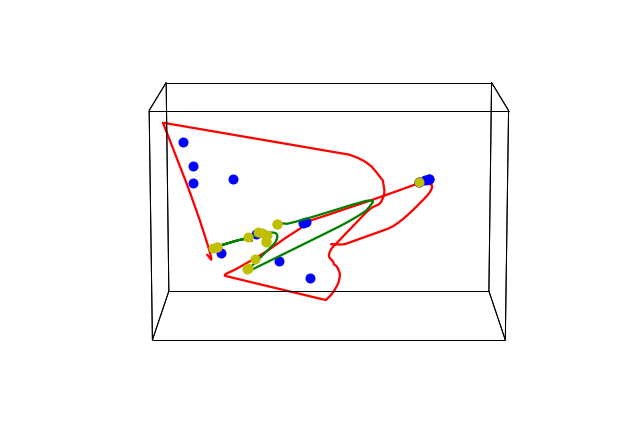

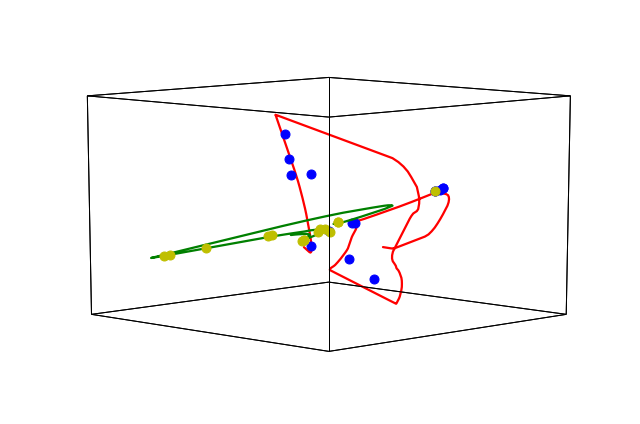

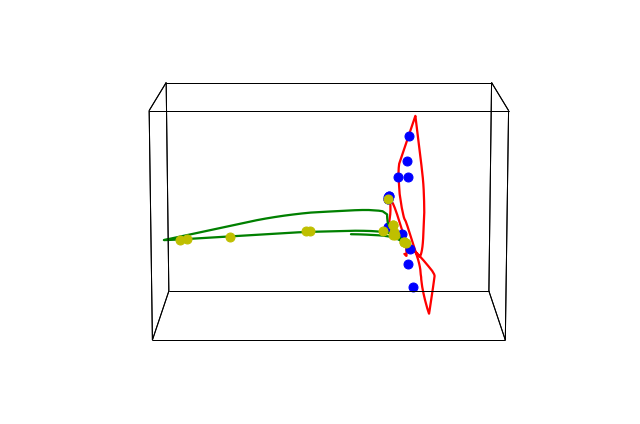

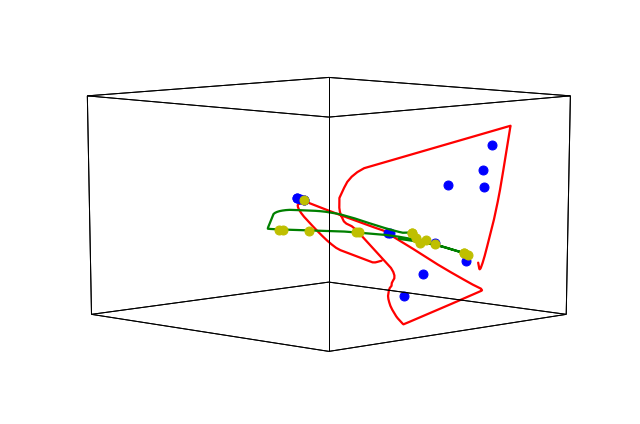

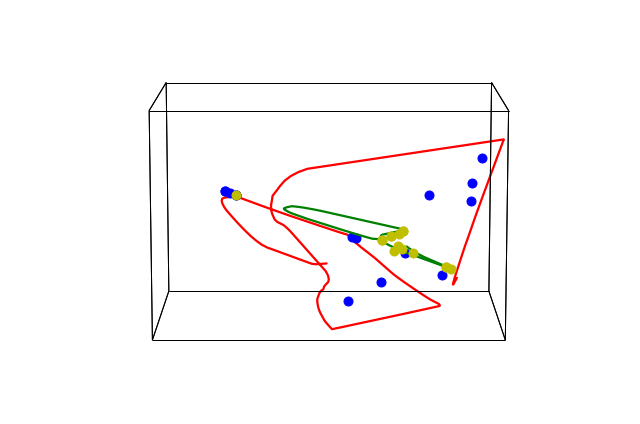

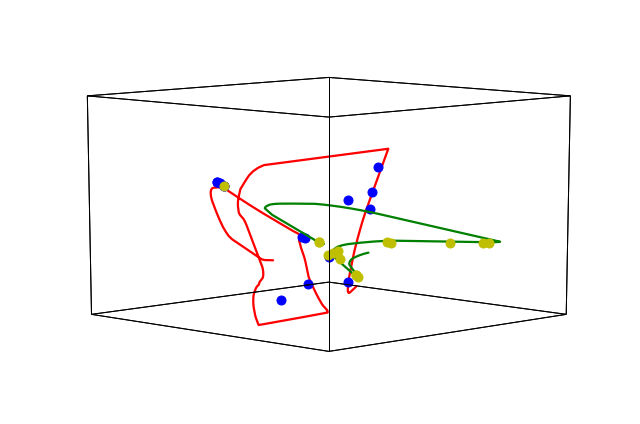

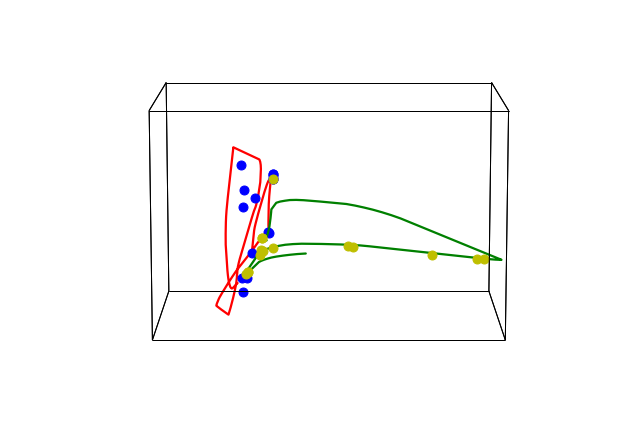

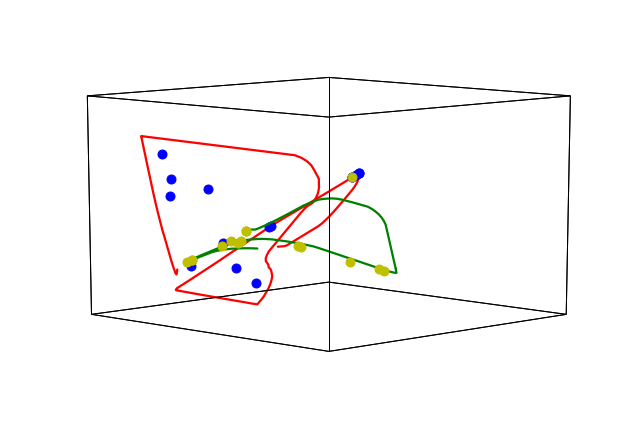

In [57]:
# spot check modeling of lectures and related questions
for azim in range(0, 360, 45):
    
    hyp.plot([forces_v_traj, forces_q_traj, bos_v_traj, bos_q_traj], fmt=['r-', 'bo', 'g-', 'yo'],
             reduce='IncrementalPCA', size=[9, 6], azim=azim)
    plt.show()

# _Four Forces_

In [58]:
sns.set_context('talk')
sns.set_style('white')

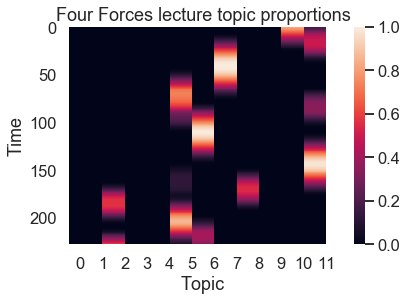

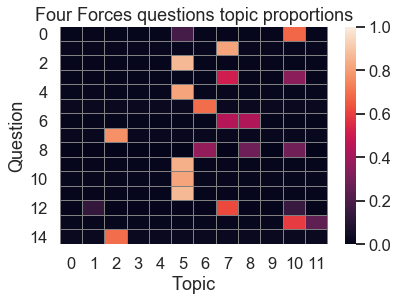

In [59]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(forces_v_traj, vmin=0, vmax=1, yticklabels=50)
a.set_title('Four Forces lecture topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(forces_v_traj, aspect='auto')
# plt.savefig(figdir+'fit_all/forces-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
a.set_title('Four Forces questions topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Question')
plt.yticks(rotation=0)
# plt.savefig(figdir+'fit_all/forces-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

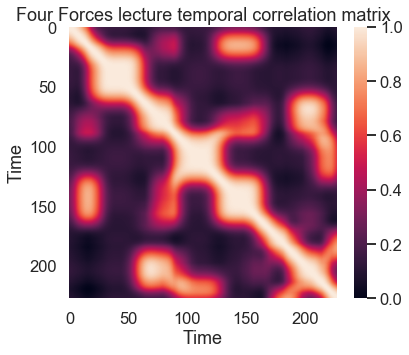

In [60]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6, 5)
a = sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1, xticklabels=50, yticklabels=50)
a.set_title('Four Forces lecture temporal correlation matrix', y=1.04)
a.set_xlabel('Time')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(pd.DataFrame(forces_v_traj).T.corr(), aspect='auto', interpolation='bilinear')
# plt.savefig(figdir+'fit_all/forces-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

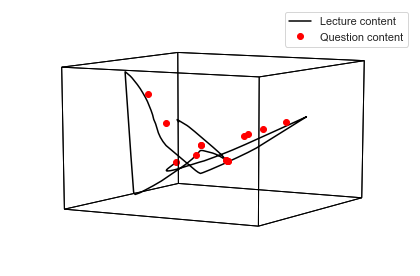

In [61]:
sns.set_context('notebook')
hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [62]:
sns.set_palette('hls', 15)
sns.set_context('talk')

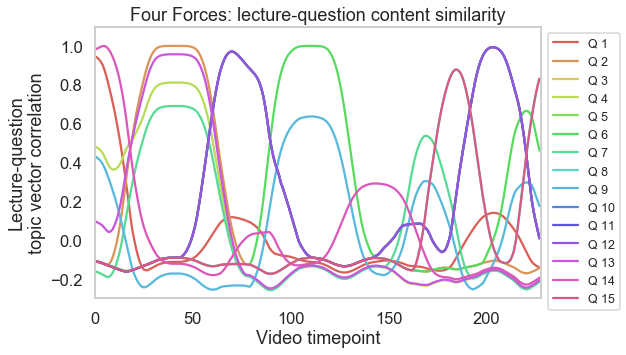

In [63]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
plt.xlim(0,forces_v_traj.shape[0])
plt.ylim(-.3,1.1)
plt.xlabel('Video timepoint')
plt.ylabel('Lecture-question\ntopic vector correlation')
plt.title('Four Forces: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1))
plt.grid(False)
# plt.savefig(figdir+'fit_all/forces-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct each subject's learning trace for each set of questions viewed

In [64]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [66]:
avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [67]:
sns.set_context('notebook')

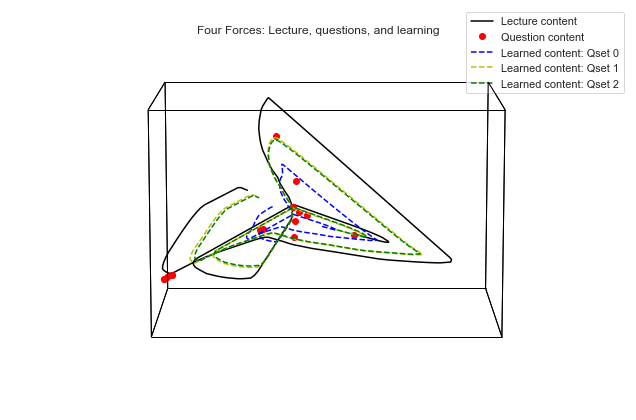

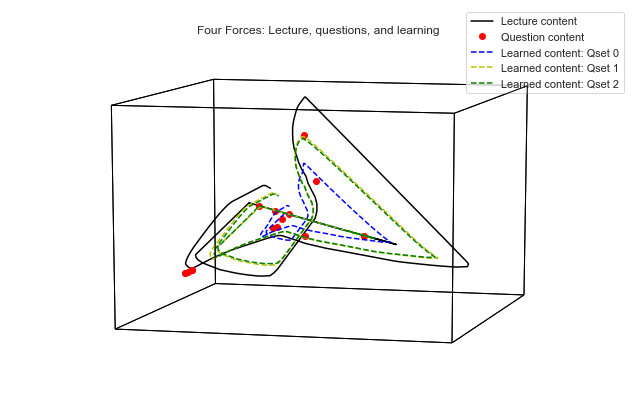

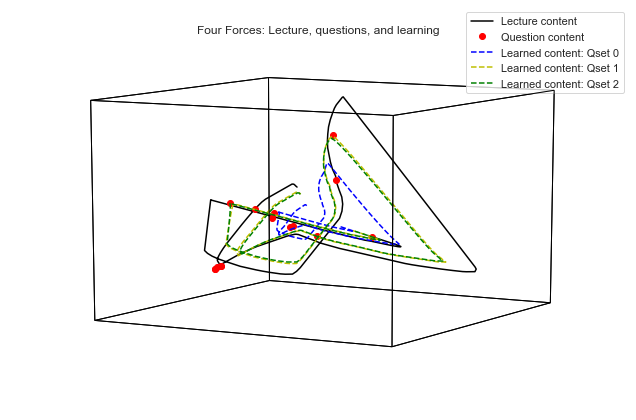

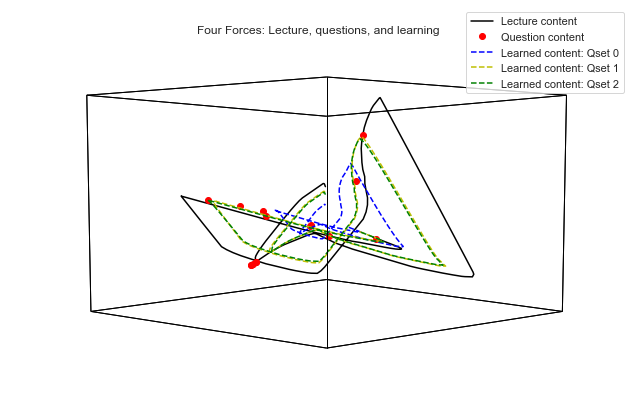

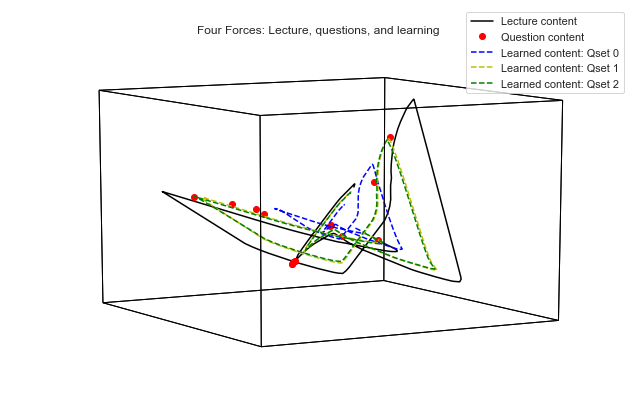

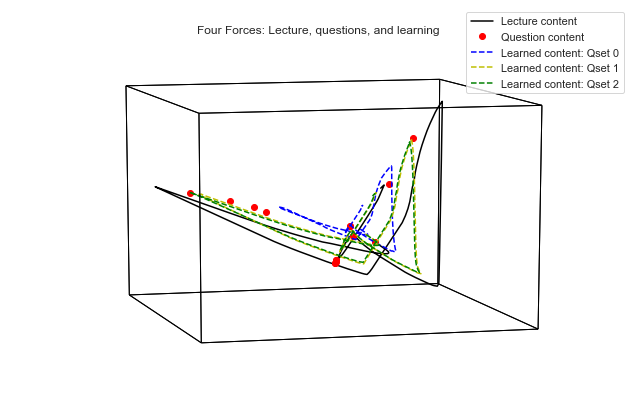

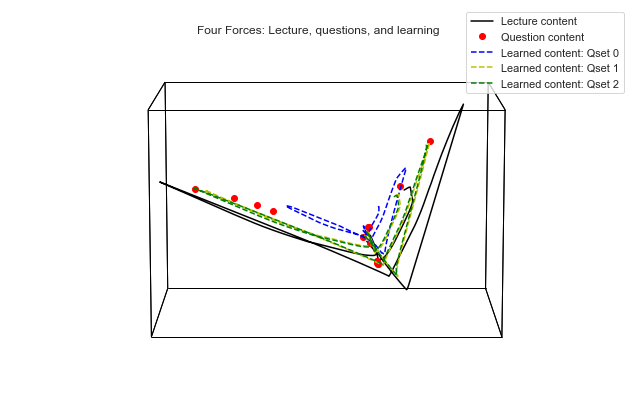

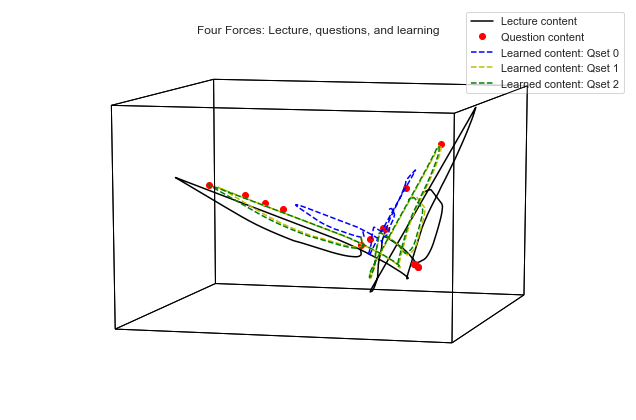

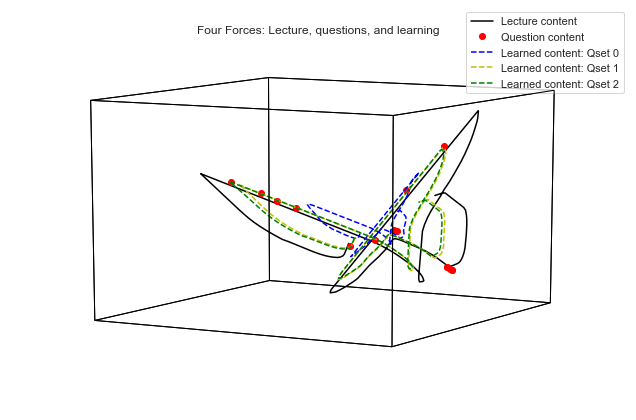

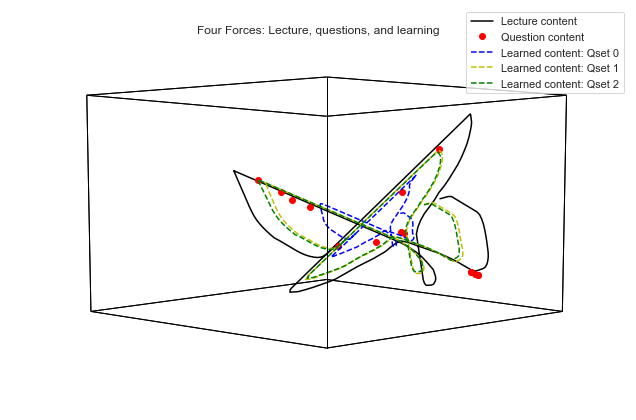

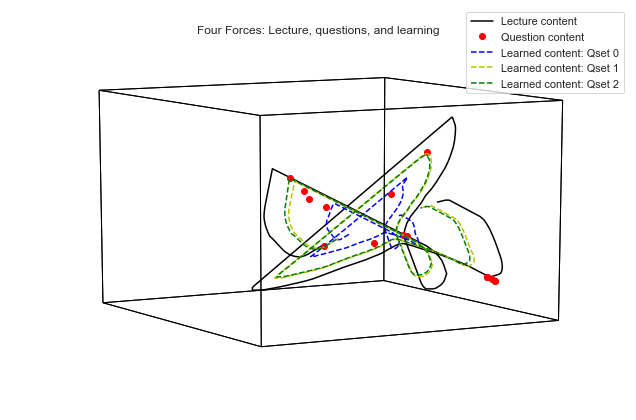

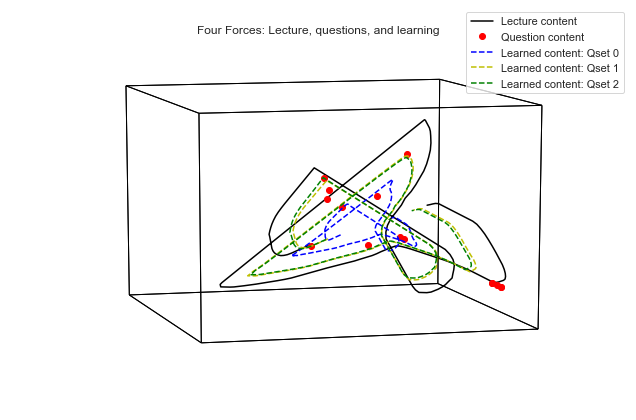

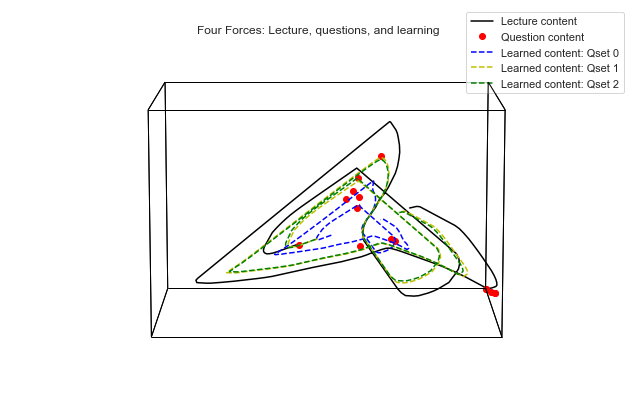

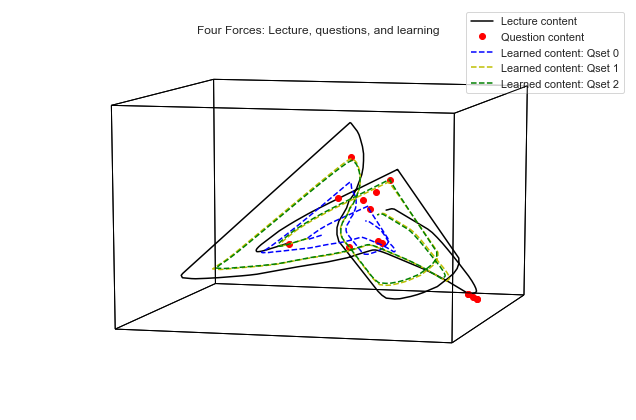

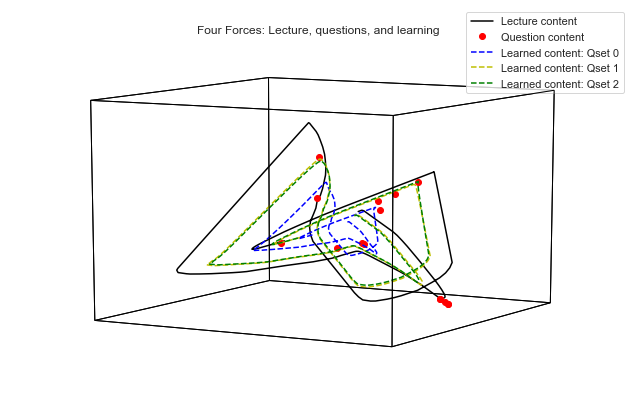

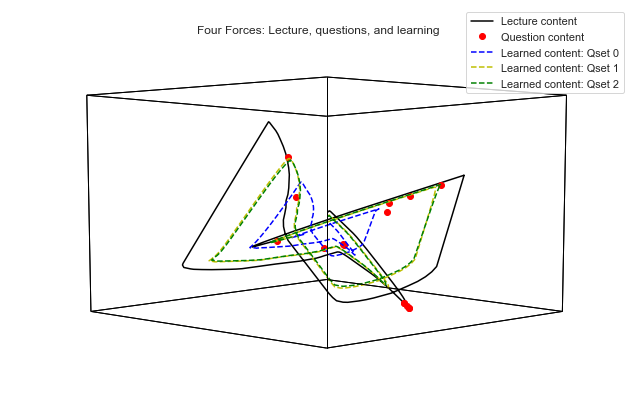

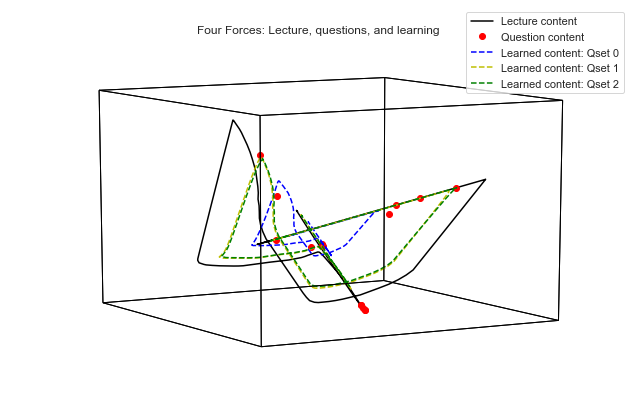

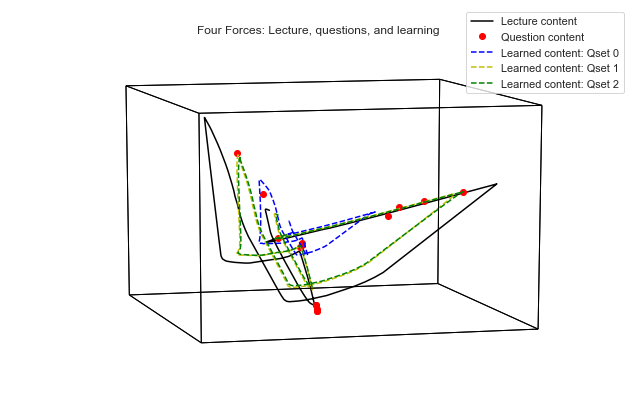

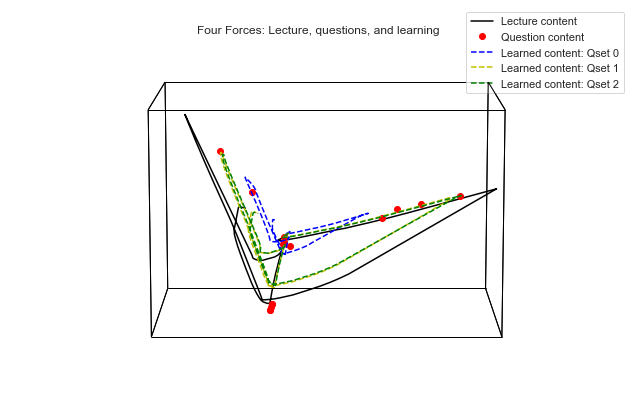

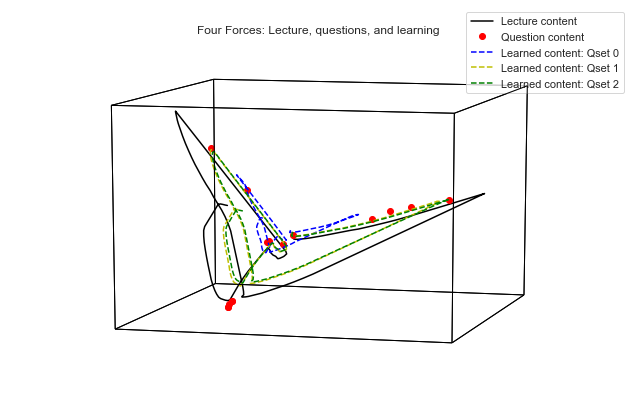

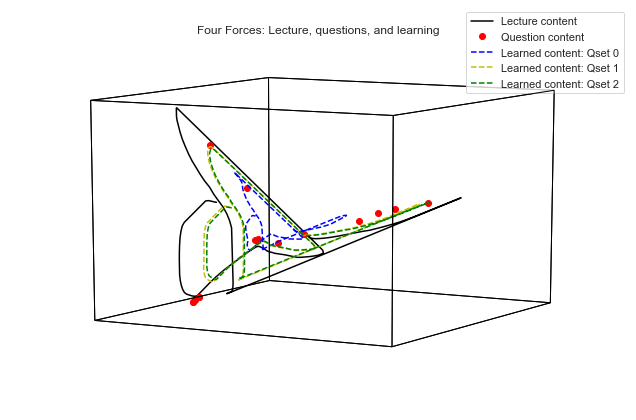

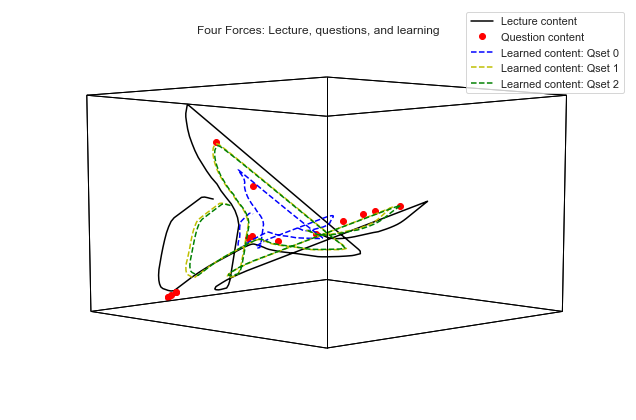

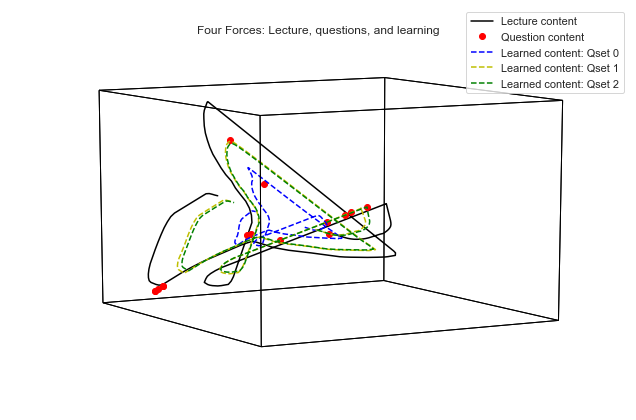

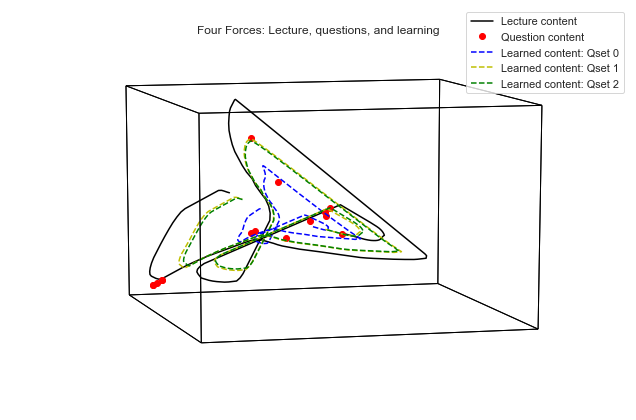

In [68]:
for azim in range(0, 360, 15):
    hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
             fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6], azim=azim,
             title='Four Forces: Lecture, questions, and learning',
             legend=['Lecture content', 'Question content', 
                     'Learned content: Qset 0', 
                     'Learned content: Qset 1', 
                     'Learned content: Qset 2'])#,
#              save_path=figdir+f'fit_all/forces-traces-plots/forces-reconstructed-{azim}.pdf')
    
    plt.show()

### How does the difference between viewed and learned content change after viewing the lecture?

In [69]:
# pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
def distance(x, y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [70]:
distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
                      for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [71]:
sns.set_palette('hls')
sns.set_context('talk')
sns.set_style('white')

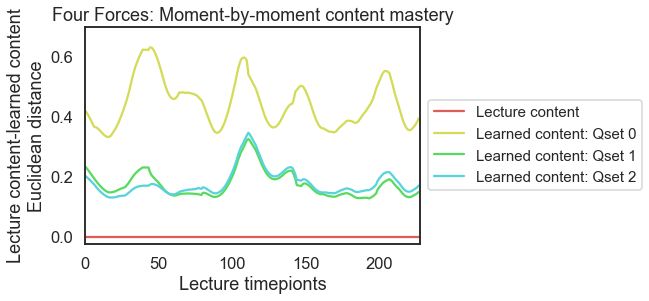

In [72]:
plt.plot(np.hstack([perfect, distances]))
plt.ylim(-.025, .7)
plt.xlim(0, forces_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Four Forces: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

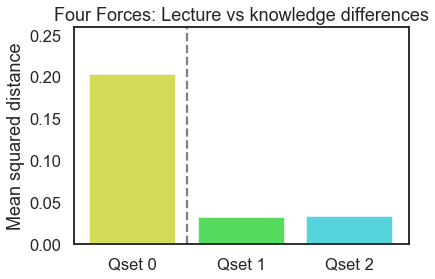

In [73]:
plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.ylabel('Mean squared distance')
plt.title('Four Forces: Lecture vs knowledge differences')
plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/forces-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

# _Birth of Stars_

In [74]:
sns.set_context('talk')

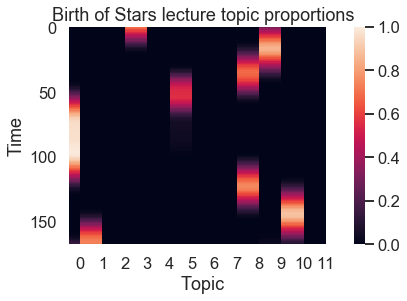

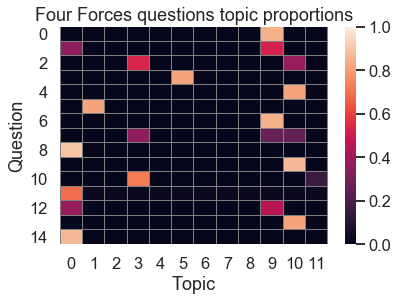

In [75]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(bos_v_traj, vmin=0, vmax=1, yticklabels=50)
a.set_title('Birth of Stars lecture topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(bos_v_traj, aspect='auto')
# plt.savefig(figdir+'fit_all/bos-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()


fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
a.set_title('Four Forces questions topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Question')
plt.yticks(rotation=0)
# plt.savefig(figdir+'fit_all/bos-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

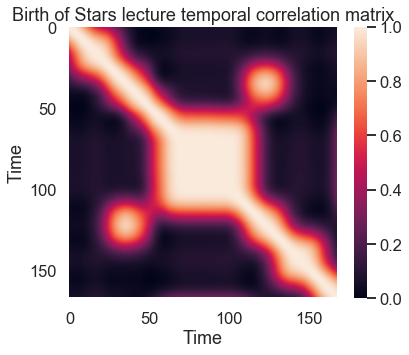

In [76]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6, 5)
a = sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1, xticklabels=50, yticklabels=50)
a.set_title('Birth of Stars lecture temporal correlation matrix', y=1.04)
a.set_xlabel('Time')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(pd.DataFrame(bos_v_traj).T.corr(), aspect='auto', interpolation='bilinear')
# plt.savefig(figdir+'fit_all/bos-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

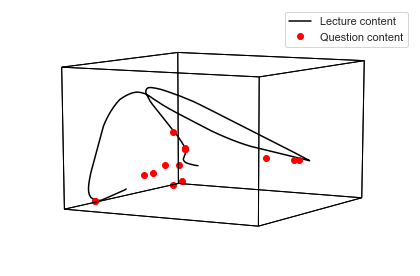

In [77]:
sns.set_context('notebook')
hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [78]:
sns.set_palette('hls', 15)
sns.set_context('talk')

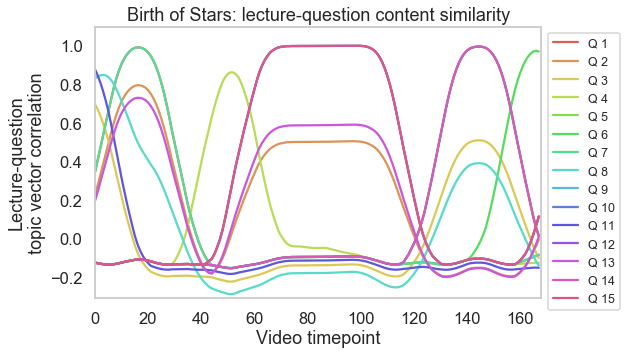

In [79]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
plt.xlim(0,bos_v_traj.shape[0])
plt.ylim(-.31,1.1)
plt.xlabel('Video timepoint')
plt.ylabel('Lecture-question\ntopic vector correlation')
plt.title('Birth of Stars: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1))
plt.grid(False)
# plt.savefig(figdir+'fit_all/bos-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [80]:
bos_traces_set0 = {}
bos_traces_set1 = {}
bos_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
    # extract their topic vectors by index
    set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
    # extract their topic vectors by index
    set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
    # extract their topic vectors by index
    set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [81]:
avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [85]:
sns.set_context('notebook')

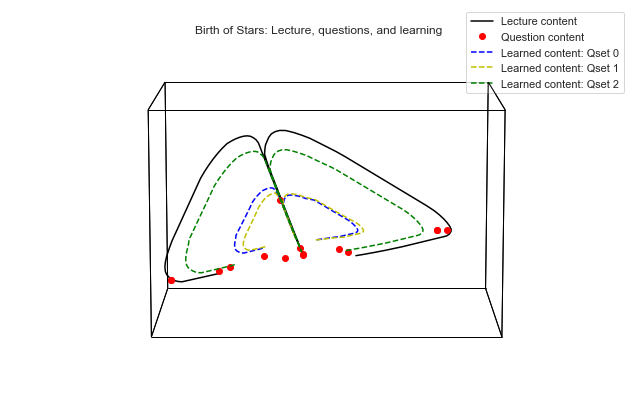

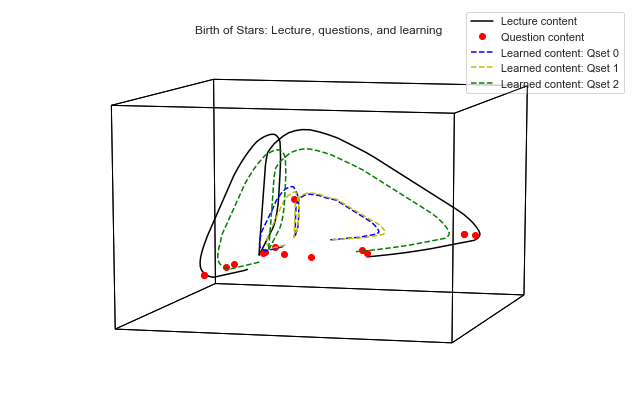

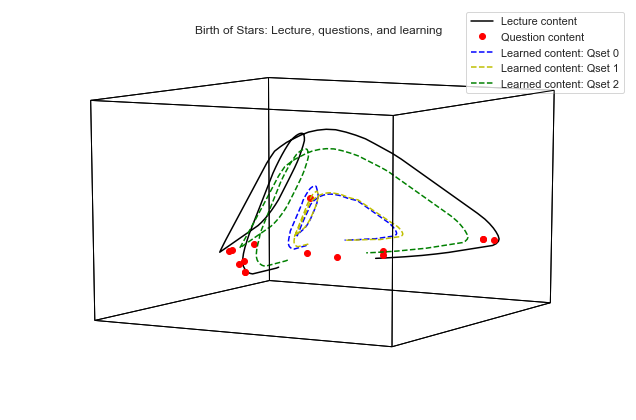

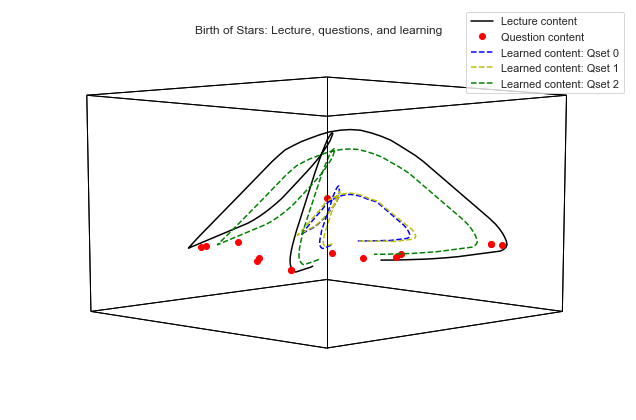

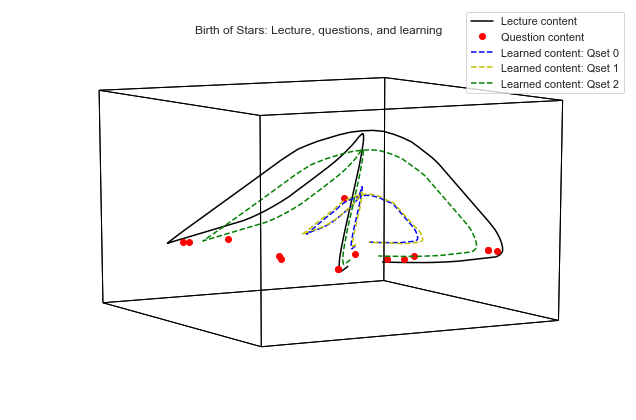

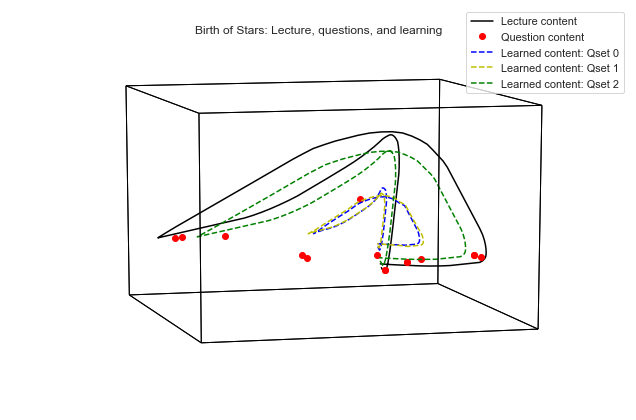

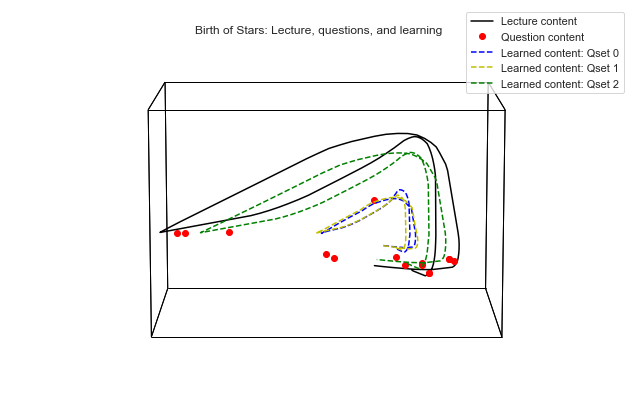

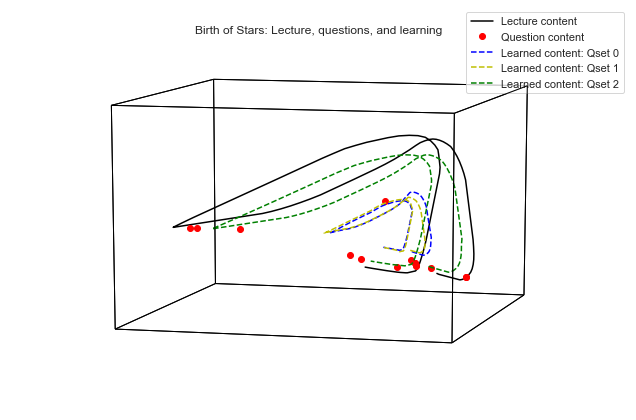

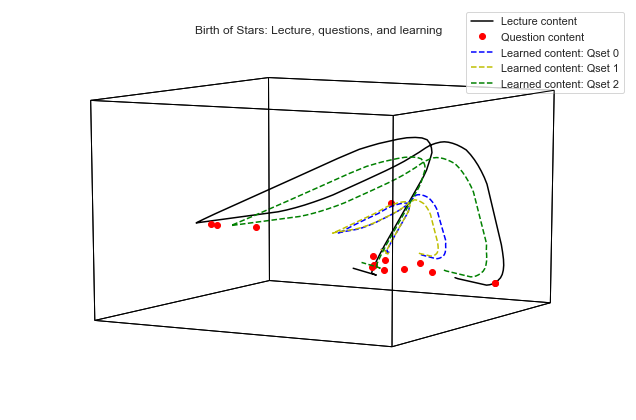

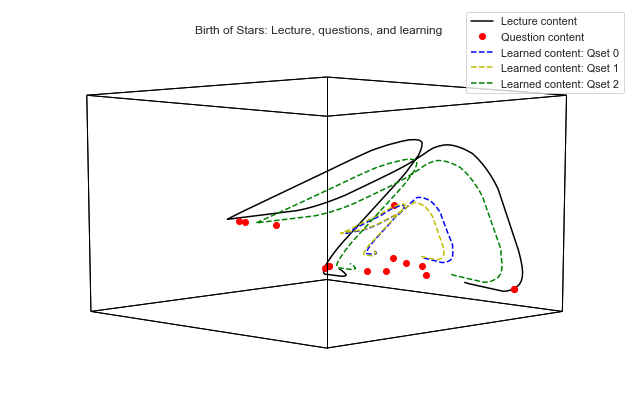

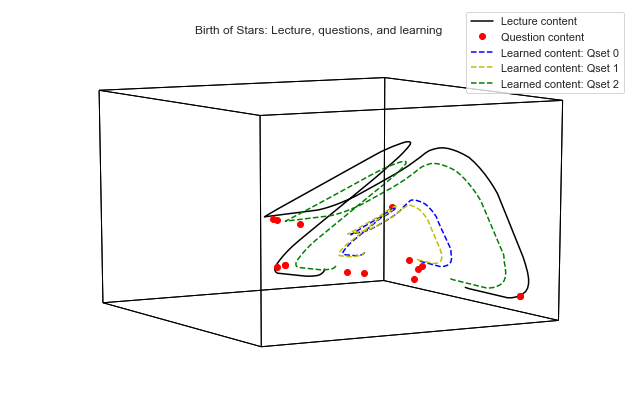

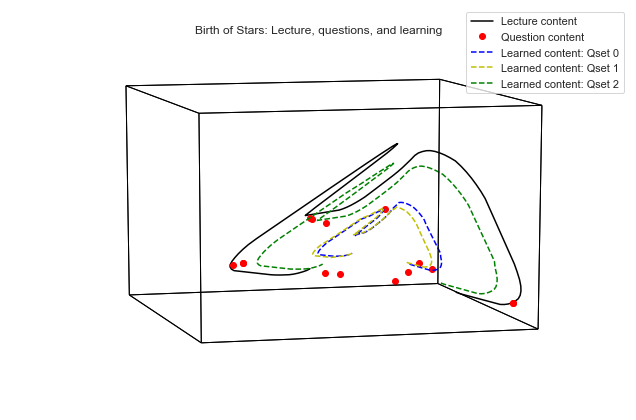

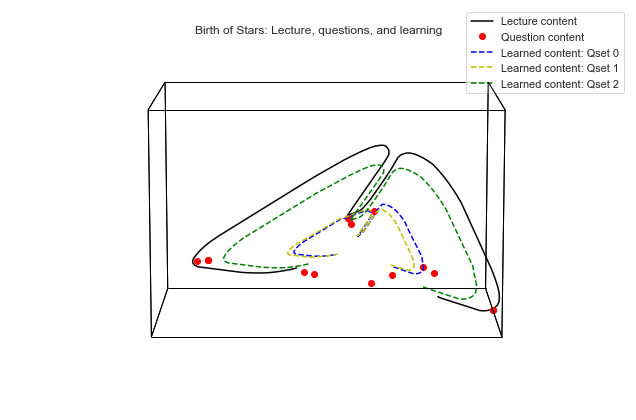

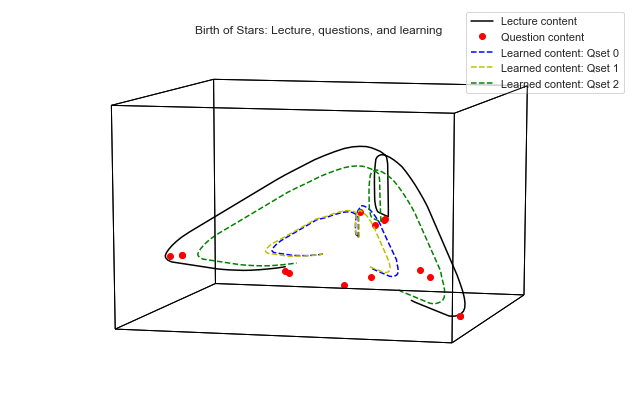

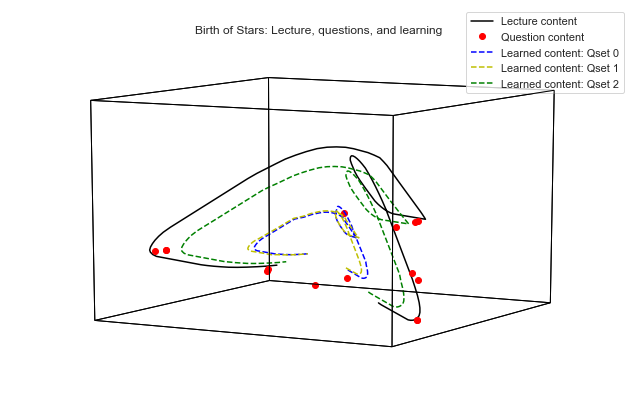

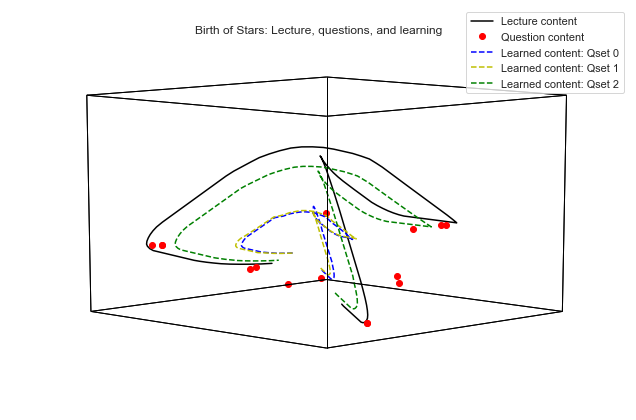

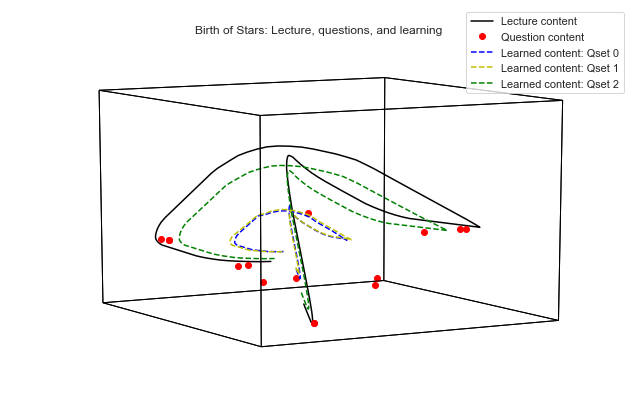

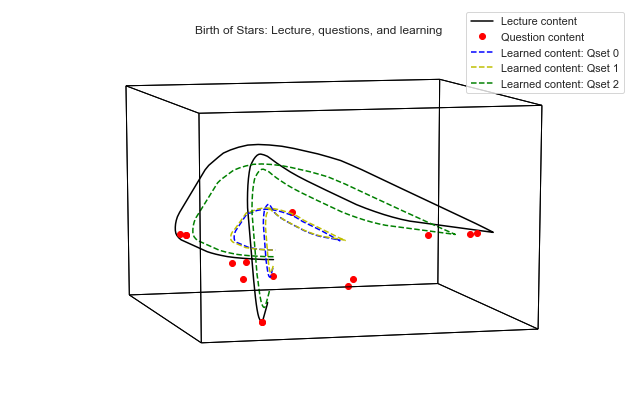

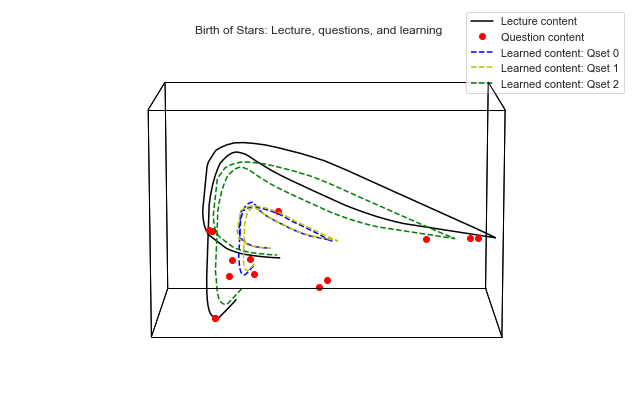

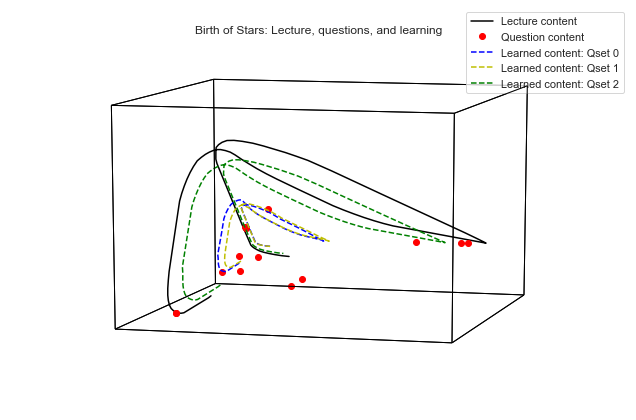

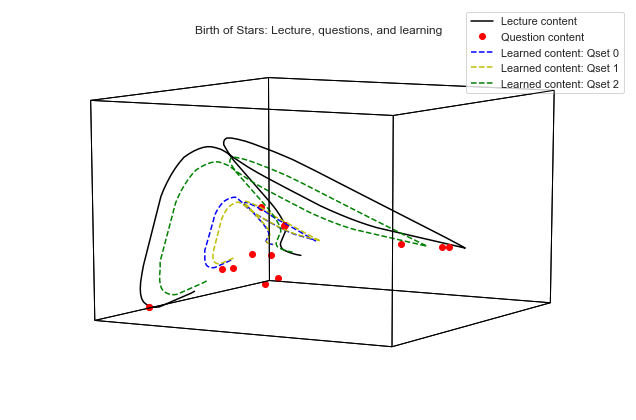

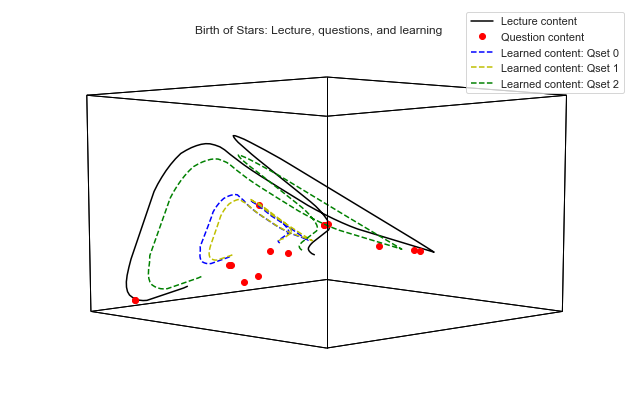

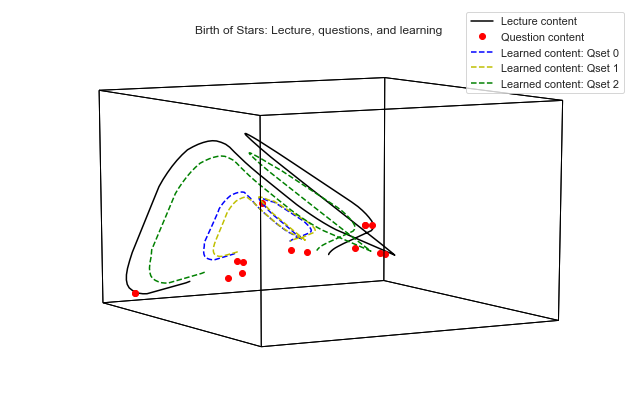

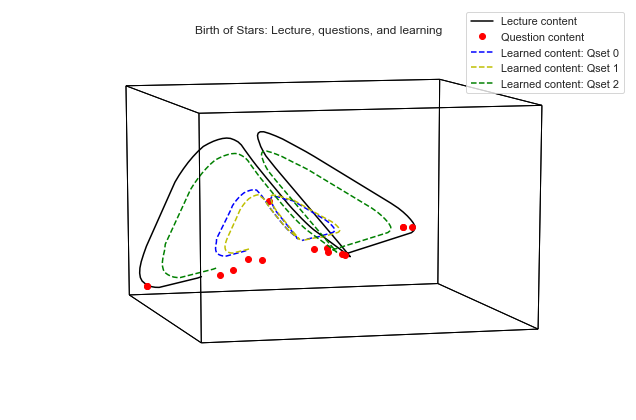

In [86]:
for azim in range(0, 360, 15):
    hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6], azim=azim,
         title='Birth of Stars: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, 
#     save_path=figdir+f'fit_all/bos-traces-plots/bos-reconstructed-{azim}.pdf')
    
    plt.show()

### How does the difference between viewed and learned content change after viewing the lecture?

In [87]:
bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
                      for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [88]:
sns.set_palette('hls')
sns.set_context('talk')
sns.set_style('white')

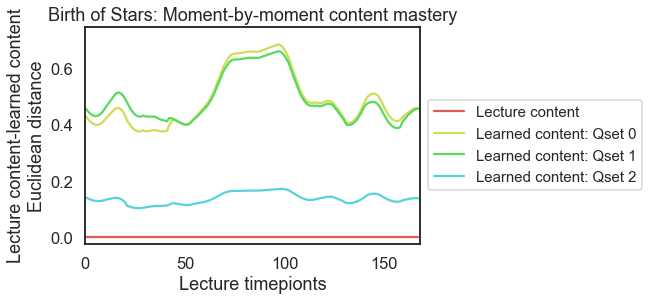

In [89]:
plt.plot(np.hstack([bos_perfect, bos_distances]))
plt.ylim(-.025, .75)
plt.xlim(0, bos_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Birth of Stars: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

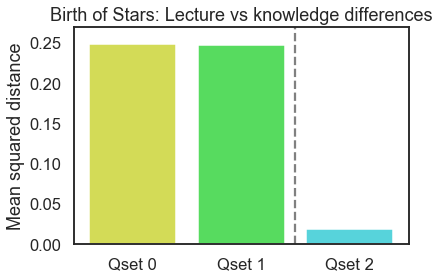

In [90]:
plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.27)
plt.ylabel('Mean squared distance')
plt.title('Birth of Stars: Lecture vs knowledge differences')
plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/bos-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

### are lecture 2 questions more closely related to lecture 1 easier to get right?

In [124]:
# BOS-related questions presented after viewing BOS lecture
bos_set2 = data_df.loc[(data_df.set == 2) & (data_df.video == 2)]
# number of times each was presented in block
bos_set2_npres = bos_set2.qID.value_counts()
# number of times each was answered correctly
bos_set2_ncorrect = bos_set2.loc[bos_set2['correct?'] == 1].qID.value_counts()
# across-participants accuracy on each question
bos_set2_success = bos_set2_ncorrect.sort_index() / bos_set2_npres.sort_index()
# distance between each question and nearest point on FF lecture trajectory
lec1_dist = cdist(bos_q_traj, forces_v_traj).min(axis=1)

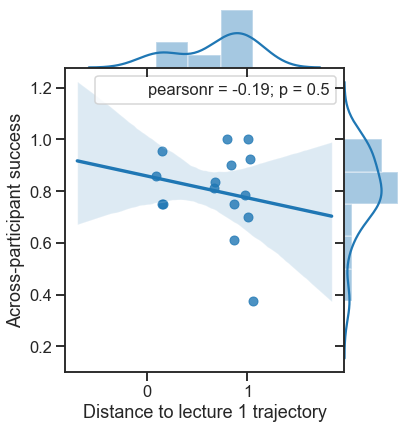

In [125]:
sns.set_palette('tab10')
sns.set_context('talk')
sns.set_style('ticks', {'axes.grid' : False})
sns.jointplot(lec1_dist, bos_set2_success, kind='reg', stat_func=pearsonr, space=0)
plt.xlabel("Distance to lecture 1 trajectory")
plt.ylabel("Across-participant success")
plt.show()

### are sections of lecture 2 that are more closely related to lecture 1 easier to learn?

0.7539411909972141 4.18244883150105e-32


Text(0.1, 0.73, '$p<0.01$')

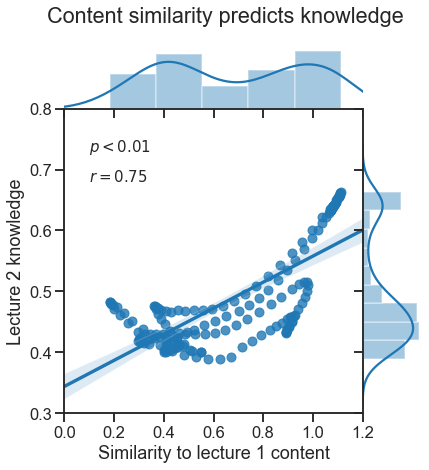

In [126]:
# x-axis: distance between lecture 2 trajectory point and nearest point on lecture 1 trajectory
# y-axis: distance between lecture 2 trajecotry point and corresponding learning trajectory point

sns.jointplot(cdist(bos_v_traj, forces_v_traj).min(axis=1), np.diag(cdist(bos_v_traj, avg_bos_trace1)), 
              kind='reg', space=0)
plt.xlabel('Similarity to lecture 1 content')
plt.ylabel('Lecture 2 knowledge')
plt.suptitle('Content similarity predicts knowledge', y=1.05)
plt.xlim(0, 1.2)
plt.ylim(0.3, 0.8)

r, p = pearsonr(cdist(bos_v_traj, forces_v_traj).min(axis=1), np.diag(cdist(bos_v_traj, avg_bos_trace1)))
print(r,p)
r = '=' + str(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p))
else:
    p = '<0.01'

plt.text(0.1,0.68, f'$r{r}$', ha='left', fontsize=15)   
plt.text(0.1,0.73, f'$p{p}$', ha='left', fontsize=15)

# plt.savefig(figdir+'fit_all/bos-success-by-ff-similarity.pdf', bbox_inches='tight')
# plt.show()

In [127]:
# x-axis: for the lecture 1 trajectory timepoint closest to each lecture 2 trajecotry timepoint, the distance 
# between it and the corresponding lecture 1 learning trajectory timepoint
# y-axis: distance between lecture 2 trajectory tiempoint and corresponding lecture 2 learning trajectory timepoint

lec2_trace1_dist = np.diag(cdist(bos_v_traj, avg_bos_trace1))
lec1rel_trace1_dist = np.diag(cdist(forces_v_traj[cdist(bos_v_traj, forces_v_traj).argmin(axis=1)], avg_force_trace1))

sns.jointplot(lec1rel_trace1_dist, lec2_trace2_dist, kind='reg', space=0)
plt.xlabel('Knowledge of most similar\nlecture 1 content')
plt.ylabel('Knowledge of lecture 2 content')
plt.suptitle('Lecture 1 performance predicts\nlecture 2 content learning', y=1.05)
plt.xlim(0, 1.2)
plt.ylim(0.3, 0.8)

r, p = pearsonr(lec1rel_trace1_dist, lec2_trace1_dist)
print(r,p)
r = '={:.2f}'.format(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p))
else:
    p = '<0.01'

plt.text(0.05,0.4, f'$r{r}$', ha='left', fontsize=15)   
plt.text(0.05,0.34, f'$p{p}$', ha='left', fontsize=15)

# plt.savefig(figdir+'fit_all/bos-success-by-ff-success.pdf', bbox_inches='tight')
plt.show()

NameError: name 'lec2_trace2_dist' is not defined

### How does success answering different questions relate?

In [130]:
sns.set_style('white')

In [132]:
subs_acc = {f'qset{q}' : {f'video{v}' : None for v in range(3)} for q in range(3)}

for qset in range(3):
    for video in range(3):
        data = data_df.loc[(data_df.set == qset) & (data_df.video == video)]
        acc = []
        
        for sub in data.participantID.unique():
            acc.append(len(data.loc[(data.participantID == sub) & (data['correct?'] == 1)]) 
                       / len(data.loc[data.participantID == sub]))
        subs_acc[f'qset{qset}'][f'video{video}'] = acc

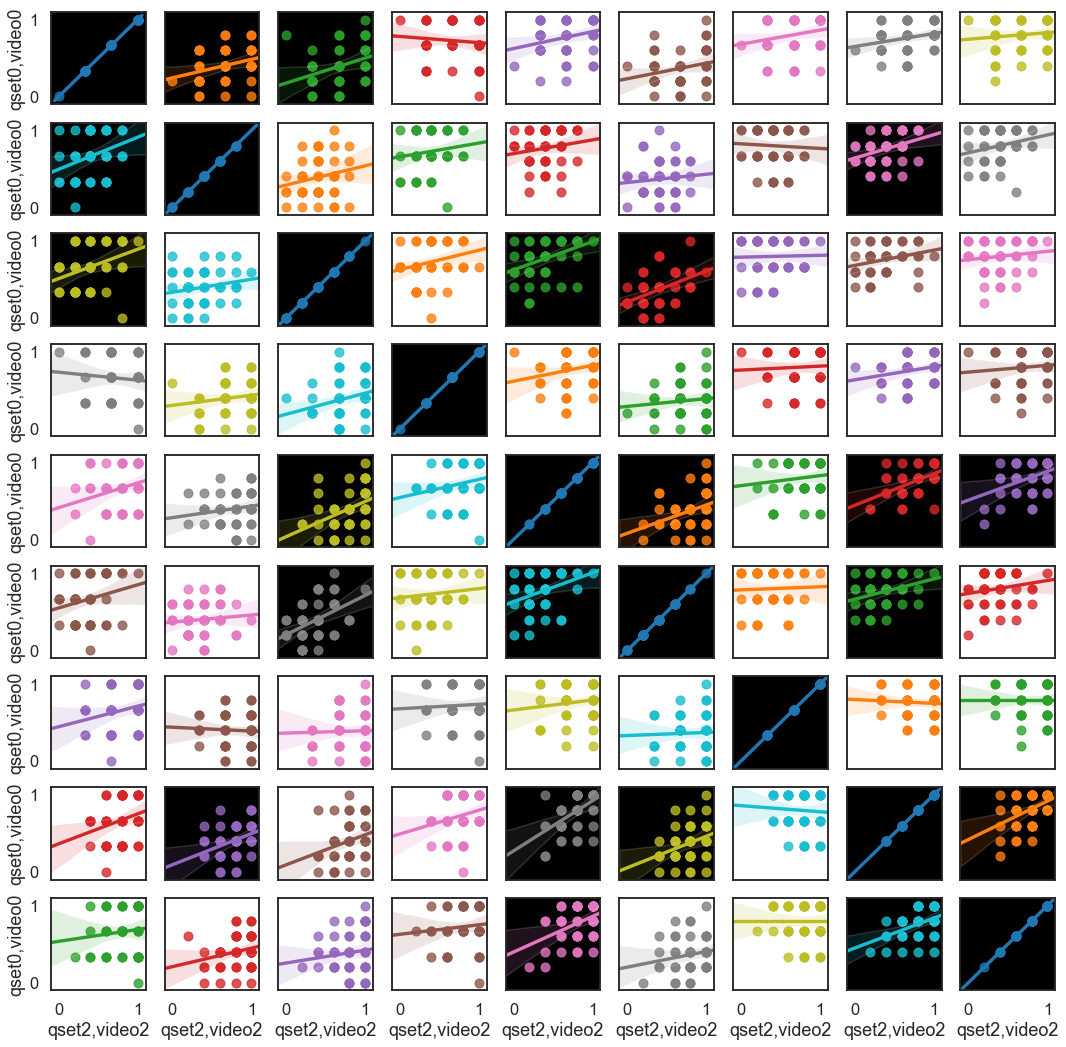

In [133]:
fig, axarr = plt.subplots(nrows=9, ncols=9, figsize=(18,18), sharex=True, sharey=True)
idx = 0

for qx, vdatax in subs_acc.items():
    for vx, accdatax in vdatax.items():
        accx = accdatax

        for qy, vdatay in subs_acc.items():
            for vy, accdatay in vdatay.items():
                accy = accdatay

                sns.regplot(accx, accy, ax=axarr.flatten()[idx])
                axarr.flatten()[idx].set_xlim(-.1,1.1)
                axarr.flatten()[idx].set_ylim(-.1,1.1)
                if not idx % 9:
                    
                    axarr.flatten()[idx].set_ylabel(f'{qy},{vy}')
                if idx >= 72:
                    axarr.flatten()[idx].set_xlabel(f'{qx},{vx}')
                    
                r, p = pearsonr(accx, accy)
                if p < 0.05:
                    axarr.flatten()[idx].set_facecolor('k')
                    
                idx += 1
                


# fig.suptitle('Proportion correct, by question set, by reference video')
plt.show()

In [134]:
stats = np.empty((3,3), dtype=object)
for x, (qset_x, data_x) in zip(range(3), subs_acc['qset0'].items()):
    for y, (qset_y, data_y) in zip(range(3), subs_acc['qset0'].items()):
        r, p = pearsonr(data_x, data_y)
        print(qset_x, qset_y)
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'

video0 video0
video0 video1
video0 video2
video1 video0
video1 video1
video1 video2
video2 video0
video2 video1
video2 video2


In [135]:
sns.set_style('white')
cmap = sns.cm.rocket_r

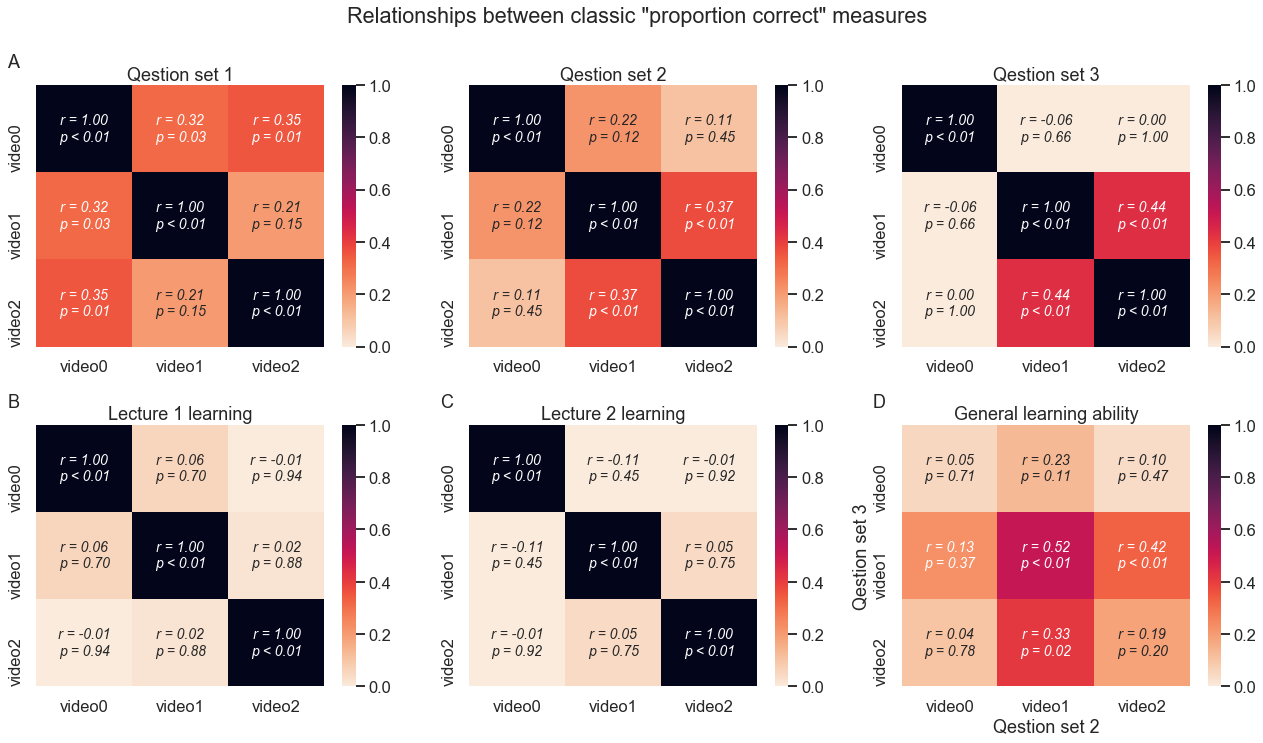

In [136]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=False, sharey=False)
axarr = axarr.flatten()

# (a)
for idx, ax in enumerate(axarr[:3]):
    
    stats = np.empty((3,3), dtype=object)
    for x, (qset_x, data_x) in zip(range(3), subs_acc[f'qset{idx}'].items()):
        for y, (qset_y, data_y) in zip(range(3), subs_acc[f'qset{idx}'].items()):
            r, p = pearsonr(data_x, data_y)
            r = '= {:.2f}'.format(round(r, 2))
            if p < 0.01:
                p = '< 0.01'
            else:
                p = '= {:.2f}'.format(round(p, 2))
            stats[x,y] = f'r {r}\np {p}'
            
    sns.heatmap(pd.DataFrame(subs_acc[f'qset{idx}']).corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=ax)

    ax.set_title(f'Qestion set {idx+1}')
    for annot in ax.texts:
        annot.set_size(14)
        annot.set_style('italic')
    
    if idx == 0:
        ax.text(x=-.3, y=-.2, s='A')

        
# (b)
data = pd.DataFrame(subs_acc['qset1']) - pd.DataFrame(subs_acc['qset0'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), data.columns):
    for y, col_y in zip(range(3), data.columns):
        r, p = pearsonr(data[col_x], data[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        
sns.heatmap(data.corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[3])

axarr[3].set_title(f'Lecture 1 learning')
for annot in axarr[3].texts:
    annot.set_size(14)
    annot.set_style('italic')
axarr[3].text(x=-.3, y=-.2, s='B')

    
# (c)
data = pd.DataFrame(subs_acc['qset2']) - pd.DataFrame(subs_acc['qset1'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), data.columns):
    for y, col_y in zip(range(3), data.columns):
        r, p = pearsonr(data[col_x], data[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        
sns.heatmap(data.corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[4])

axarr[4].set_title(f'Lecture 2 learning')
for annot in axarr[4].texts:
    annot.set_size(14)
    annot.set_style('italic')
axarr[4].text(x=-.3, y=-.2, s='C')
    
    
# (d)
d1 = pd.DataFrame(subs_acc['qset1'])
d2 = pd.DataFrame(subs_acc['qset2'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), d1.columns):
    for y, col_y in zip(range(3), d2.columns):
        r, p = pearsonr(d1[col_x], d2[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'

sns.heatmap(d1.apply(lambda x: d2.corrwith(x)), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[5])

axarr[5].set_title(f'General learning ability')
for annot in axarr[5].texts:
    annot.set_size(14)
    annot.set_style('italic')

axarr[5].set_xlabel('Qestion set 2')
axarr[5].set_ylabel('Qestion set 3')
axarr[5].text(x=-.3, y=-.2, s='D')

fig.suptitle('Relationships between classic "proportion correct" measures', y=1.04)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
# plt.savefig(figdir+'fit_all/prop-correct-heatmaps.pdf', bbox_inches='tight')

plt.show()

0.05461421465307265
0.2300134518703703
0.10402707552966235
0.12994803117921455
0.5176043276833591
0.4165000999333799
0.04039167875761248
0.32823232087494836
0.1851285276390572


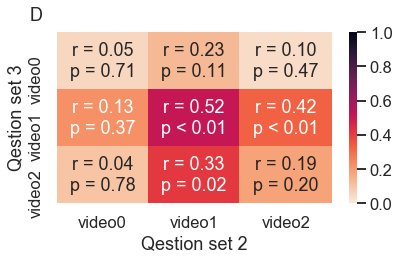

In [137]:
# (d)
d1 = pd.DataFrame(subs_acc['qset1'])
d2 = pd.DataFrame(subs_acc['qset2'])
sns.heatmap(d1.apply(lambda x: d2.corrwith(x)), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='')

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), d1.columns):
    for y, col_y in zip(range(3), d2.columns):
        r, p = pearsonr(d1[col_x], d2[col_y])
        print(r)
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        



plt.xlabel('Qestion set 2')
plt.ylabel('Qestion set 3')
plt.text(x=-.3, y=-.2, s='D')

# fig.suptitle('Relationships between classic "proportion correct" measures', y=1.04)
plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)
# plt.savefig(figdir+'fit_all/prop-correct-heatmaps.pdf', bbox_inches='tight')

plt.show()

### what topic dimensions are most important to success?

In [138]:
vocab = tf_vectorizer.get_feature_names()

In [139]:
# what content comprises each topic?
n_top_words = 10
topic_words = {}

for topic, component in enumerate(lda.components_):
    word_ix = np.argsort(component)[::-1][:n_top_words]
    topic_words[topic] = [vocab[i] for i in word_ix]
    
for topic, words in topic_words.items():
    print(f'topic {topic}:\n{", ".join(words)}')

topic 0:
fusion, ignition, pressure, actually, mass, hydrogen, protons, energy, gets, little
topic 1:
threshold, jupiter, like, theres, temperature, quite, fuse, actually, level, fusion
topic 2:
charge, positive, mass, coulomb, force, negative, big, lump, neutral, concentrations
topic 3:
denser, slowly, going, atoms, forward, fast, hydrogen, mass, cloud, huge
topic 4:
condensing, force, denser, gotten, different, frames, temperature, hydrogen, center, mind
topic 5:
force, strong, gravity, interaction, times, distances, strength, stronger, actually, reason
topic 6:
force, huge, electromagnetic, like, scales, way, concentrations, macro, charges, theres
topic 7:
weak, interaction, proton, going, neutrons, extra, protons, neutron, cesium, actually
topic 8:
hydrogen, nucleus, helium, atom, protons, electron, atoms, electrons, draw, atomic
topic 9:
really, hydrogen, atoms, temperature, center, dense, going, condensing, gotten, theres
topic 10:
helium, atomic, star, main, mass, keeps, sequenc

In [140]:
for topic, words in topic_words.items():
    print(topic)
    for word in words:
        in_others = 0
        for other_words in topic_words.values():
            if word in other_words:
                in_others += 1
        
        if in_others < 2:
            print(word)

0
ignition
pressure
gets
little
1
threshold
jupiter
quite
fuse
level
2
charge
positive
coulomb
negative
big
lump
neutral
3
slowly
forward
fast
cloud
4
different
mind
5
strong
times
distances
strength
stronger
reason
6
electromagnetic
scales
way
macro
charges
7
proton
neutrons
extra
neutron
cesium
8
nucleus
atom
electron
electrons
draw
9
dense
10
star
main
keeps
sequence
scale
11
magnetic
called
electro


In [141]:
# what topics comprise each trajectory?
for traj, name in zip([forces_v_traj, forces_q_traj, bos_v_traj, bos_q_traj, general_q_traj], 
                      ['Four Forces lecture', 'Four Forces questions', 'Birth of Stars lecture', 
                       'Birth of Stars questions', 'General knowledge questions']):

    print(f'{name} topics:\n{np.squeeze(np.argwhere(np.var(traj, axis=0) > 0.001))}')

Four Forces lecture topics:
[ 2  5  6  7  8 10 11]
Four Forces questions topics:
[ 2  5  6  7  8 10 11]
Birth of Stars lecture topics:
[ 0  1  3  5  8  9 10]
Birth of Stars questions topics:
[ 0  1  3  5  9 10 11]
General knowledge questions topics:
[0 3 7 8 9]


### What concepts are most important to master in lecture 1 to successfully learn the lesson content?

In [399]:
# dict to hold correlations between displacement-learning success correlations
corrs = {}

# for each topic dimension lecture varies along
for dim in np.squeeze(np.argwhere(np.var(forces_v_traj, axis=0) > 0.001)):
    sub_corrs = []
    
    # for each participant
    for sub, trace in forces_traces_set1.items():
        
        # correlate distance between learning and lecture trajs along that dimension with total distance, tpt-wise
        single_dim_dist = np.abs(trace[:,dim] - forces_v_traj[:,dim])
        full_dist = np.diag(cdist(trace, forces_v_traj))
        if np.count_nonzero(single_dim_dist) == 0 and np.count_nonzero(full_dist) == 0:
            dim_dist_corr = 1
        else:
            dim_dist_corr = pearsonr(single_dim_dist, full_dist)[0]
            
        sub_corrs.append(dim_dist_corr)
        
    corrs[dim] = np.array(sub_corrs)
    

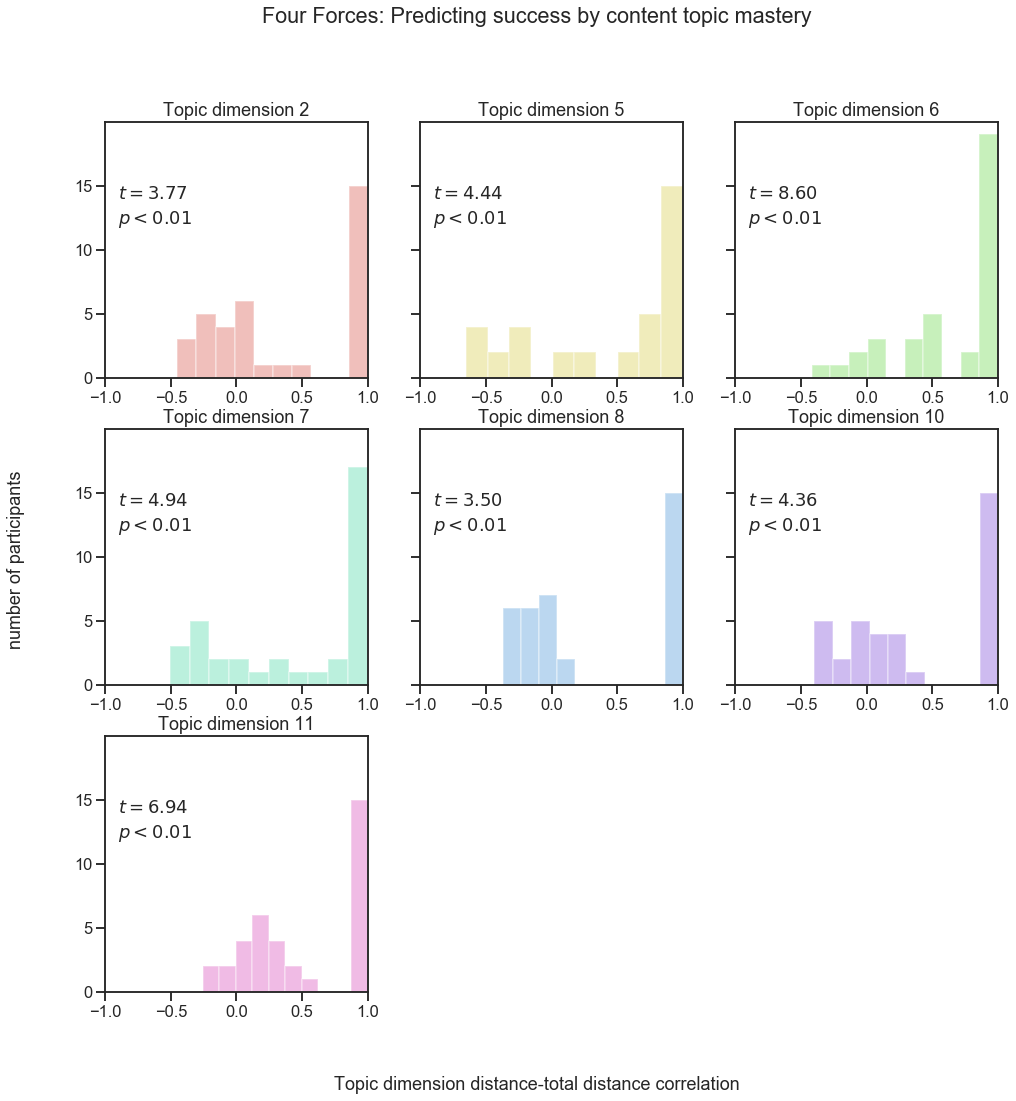

In [428]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(16, 16), sharex=False, sharey=True)
axarr = axarr.flatten()

for dim, (idx, ax) in zip(corrs.keys(), enumerate(axarr)):
    
    sns.distplot(corrs[dim], bins=10, kde=False, color=sns.color_palette('hls', 7)[idx], ax=ax)
    ax.set_xlim(-1,1)
    ax.set_title(f'Topic dimension {dim}')

    transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
    t_stat = ttest_1samp(transf_data, 0)

    t = '={:.2f}'.format(round(t_stat[0], 2))
    if t_stat[1] >= 0.01:
        p = '=' + str(round(t_stat[1]))
    else:
        p = '<0.01'

    ax.text(s=f'$t{t}$', x=-.9, y=14)
    ax.text(s=f'$p{p}$', x=-.9, y=12)
    
for ax in axarr[idx+1:]:
    ax.axis('off')

plt.subplots_adjust()
fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
fig.text(s='number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
plt.suptitle('Four Forces: Predicting success by content topic mastery')
# plt.savefig(figdir+'fit_all/forces-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
plt.show()

### What concepts are most important to master in lecture 2 to successfully learn the lesson content?

In [1019]:
# dict to hold correlations between displacement-learning success correlations
corrs = {}

# for each topic dimension lecture varies along
for dim in np.squeeze(np.argwhere(np.var(bos_v_traj, axis=0) > 0.001)):
    sub_corrs = []
    
    # for each participant
    for sub, trace in bos_traces_set2.items():
        
        # correlate distance between learning and lecture trajs along that dimension with total distance, tpt-wise
        single_dim_dist = np.abs(trace[:,dim] - bos_v_traj[:,dim])
        full_dist = np.diag(cdist(trace, bos_v_traj))
        if np.count_nonzero(single_dim_dist) == 0 and np.count_nonzero(full_dist) == 0:
            dim_dist_corr = 1
        else:
            dim_dist_corr = pearsonr(single_dim_dist, full_dist)[0]
            
        sub_corrs.append(dim_dist_corr)
        
    corrs[dim] = np.array(sub_corrs)
    
# barplot: each bar is a topic dimension, y-axis is correlation between displacement along that topic dim and
# learning success


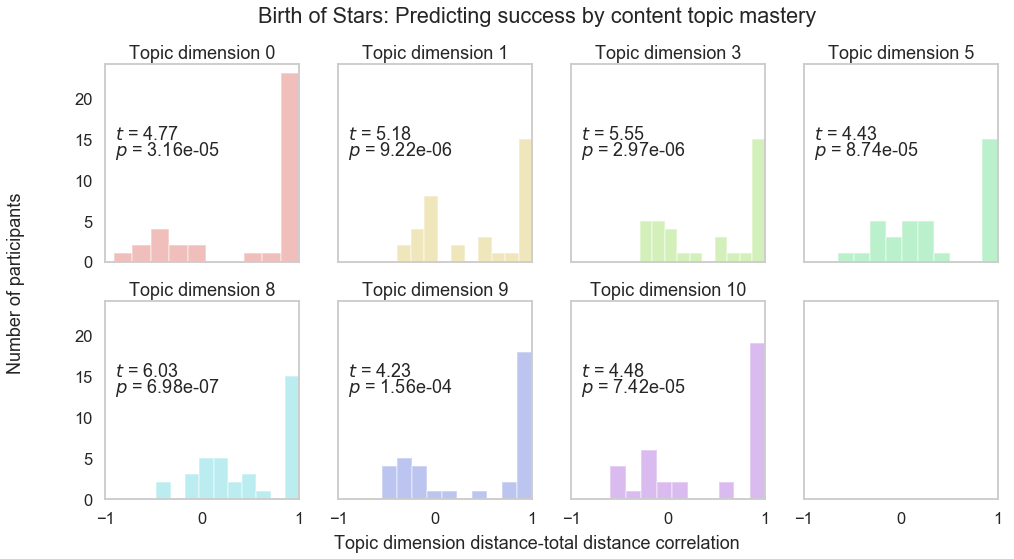

In [1020]:
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharex=True, sharey=True)

for dim, (idx, ax) in zip(corrs.keys(), enumerate(axarr.flatten())):
    
    sns.distplot(corrs[dim], bins=10, kde=False, color=sns.color_palette('hls', 8)[idx], ax=ax)
    ax.set_xlim(-1,1)
    ax.set_title(f'Topic dimension {dim}')
    
    transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
    t_stat = ttest_1samp(transf_data, 0)
    t, p = t_stat[0], t_stat[1]
    if p < 0.01:
        p = '%.2e' % Decimal(str(t_stat[1]))
    else:
        p = str(p)[:4]
    
    ax.text(s=f'$t$ = {str(t)[:4]}', x=-.9, y=15)
    ax.text(s=f'$p$ = {p}', x=-.9, y=13)
    
# axarr[1,2].axis('off')
plt.subplots_adjust()
fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
fig.text(s='Number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
plt.suptitle('Birth of Stars: Predicting success by content topic mastery')
# plt.savefig(figdir+'fit_all/bos-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
plt.show()

### What concepts are most important to take away from lecture 1 to be successful in learning lecture 2?

In [1021]:
# # dict to hold correlations between displacement-learning success correlations
# single_dims = {}
# msds = {}

# # for each topic dimension lecture varies along
# for dim in range(20):
#     sub_single_dims = []
#     sub_msds = []
    
#     # for each participant
#     for sub, trace in forces_traces_set1.items():
        
#         # get distance between learning and lecture 1 trajs along that dimension and total distance
#         # between lecture 2 and lecture 2 learning trajectory
#         single_dim_msd = ((trace[:,dim] - forces_v_traj[:,dim])**2).mean()
#         lec2_full_msd = (np.diag(cdist(bos_traces_set2[sub], bos_v_traj))**2).mean()
        
#         sub_single_dims.append(single_dim_msd)
#         sub_msds.append(lec2_full_msd)
    
#     single_dims[dim] = np.array(sub_single_dims)
#     msds[dim] = np.array(sub_msds)
    
# # barplot: each bar is a topic dimension, y-axis is correlation between displacement along that topic dim and
# # learning success


In [1022]:
# fig, axarr = plt.subplots(nrows=5, ncols=4, figsize=(20, 16))#, sharex=True, sharey=True)

# for dim, (idx, ax) in zip(single_dims.keys(), enumerate(axarr.flatten())):
#     sns.regplot(single_dims[dim], msds[dim], color=sns.color_palette('hls', 20)[idx], ax=ax)
#     ax.set_xlim(-1,1)
#     ax.set_title(f'Topic dimension {dim}')
    
# #     transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
# #     t_stat = ttest_1samp(transf_data, 0)
# #     t, p = t_stat[0], t_stat[1]
# #     if p < 0.01:
# #         p = '%.2e' % Decimal(str(t_stat[1]))
# #     else:
# #         p = str(p)[:4]
    
# #     ax.text(s=f'$t$ = {str(t)[:4]}', x=-.9, y=26)
# #     ax.text(s=f'$p$ = {p}', x=-.9, y=23)
    

# plt.subplots_adjust()
# # fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
# # fig.text(s='number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
# # plt.suptitle('Birth of Stars: Predicting success by content topic mastery')
# # # plt.savefig(figdir+'fit_all/bos-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
# plt.show()

In [430]:
traj_dir = '../data analysis/trajectories/'

In [440]:
# np.save(traj_dir+'forces_v_traj.npy', forces_v_traj)
# np.save(traj_dir+'bos_v_traj.npy', bos_v_traj)
# np.save(traj_dir+'forces_q_traj.npy', forces_q_traj)
# np.save(traj_dir+'bos_q_traj.npy', bos_q_traj)
# np.save(traj_dir+'general_q_traj.npy', general_q_traj)

In [441]:
# np.save(traj_dir+'avg_force_trace0.npy', avg_force_trace0)
# np.save(traj_dir+'avg_force_trace1.npy', avg_force_trace1)
# np.save(traj_dir+'avg_force_trace2.npy', avg_force_trace2)
# np.save(traj_dir+'avg_bos_trace0.npy', avg_bos_trace0)
# np.save(traj_dir+'avg_bos_trace1.npy', avg_bos_trace1)
# np.save(traj_dir+'avg_bos_trace2.npy', avg_bos_trace2)

In [442]:
# with open(traj_dir+'forces_traces_set0.p', 'wb') as f:
#     pickle.dump(forces_traces_set0, f)
    
# with open(traj_dir+'forces_traces_set1.p', 'wb') as f:
#     pickle.dump(forces_traces_set1, f)
    
# with open(traj_dir+'forces_traces_set2.p', 'wb') as f:
#     pickle.dump(forces_traces_set2, f)
    
# with open(traj_dir+'bos_traces_set0.p', 'wb') as f:
#     pickle.dump(forces_traces_set0, f)
    
# with open(traj_dir+'bos_traces_set1.p', 'wb') as f:
#     pickle.dump(bos_traces_set1, f)
    
# with open(traj_dir+'bos_traces_set2.p', 'wb') as f:
#     pickle.dump(bos_traces_set2, f)